In [ ]:
from adabmDCA.fasta import get_tokens, import_from_fasta, compute_weights
from adabmDCA.stats import get_freq_single_point, get_freq_two_points, get_correlation_two_points, extract_Cij_from_freq
from adabmDCA.functional import one_hot
from adabmDCA.utils import init_parameters, init_chains, get_device, get_dtype, get_mask_save
from adabmDCA.io import save_params, save_chains
from adabmDCA.plot import plot_PCA
from adabmDCA import get_seqid

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd     

# ---------- Device / dtype setup ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = get_dtype("float32")
tokens = get_tokens("protein")

In [3]:
from adabmDCA.fasta import get_tokens
from adabmDCA.utils import get_device, get_dtype
from adabmDCA.io import load_params, import_from_fasta
from adabmDCA.fasta import encode_sequence, decode_sequence
from adabmDCA.functional import one_hot
from adabmDCA.statmech import compute_energy

In [4]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Move up one level to the 'my_project' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the system path so Python can find 'src'
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"System path updated to include: {project_root}")
from src import compute_gibbs_probabilities, simulate_gibbs_trajectories
#f


System path updated to include: /home/ldibari/ldibari/ProtLatDyn


In [6]:
from src import pearson_correlation_1d, cosine_sim, compute_cosine_curve

In [7]:
from src import calculate_forces_and_noises, generate_dms_and_project_batch_timed

## trial pca 

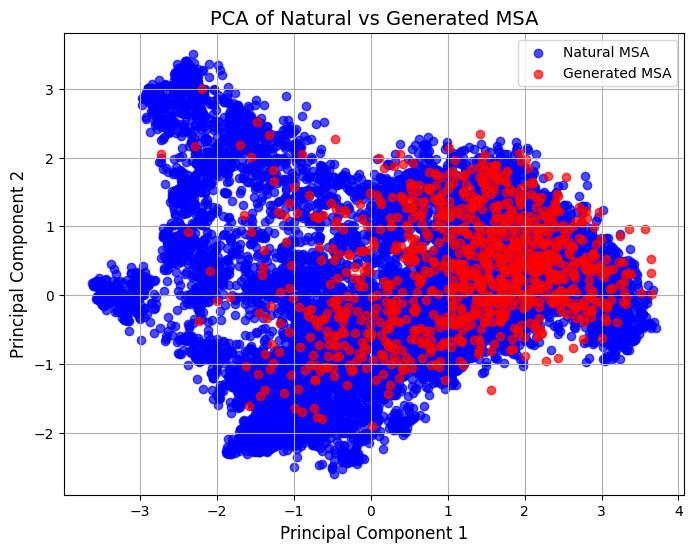

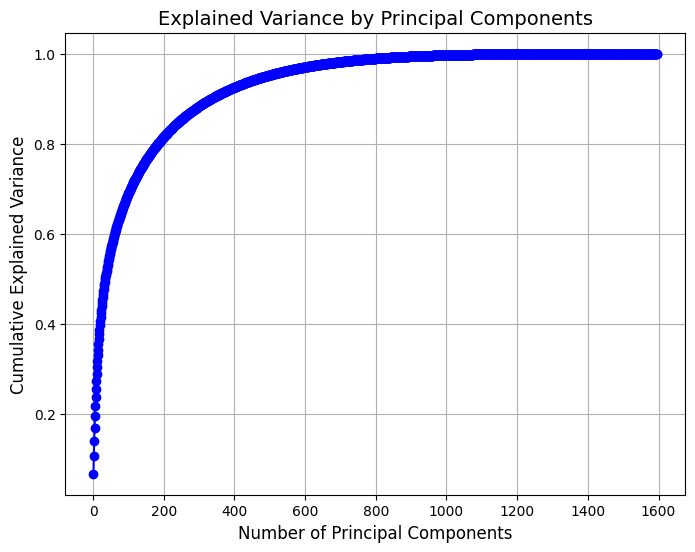

Explained Variance Ratio by each principal component:
[6.6902176e-02 3.9510638e-02 3.2980386e-02 ... 1.4949245e-17 5.6837089e-18
 8.7676058e-19]


In [9]:

params = load_params("../data/DBD_full/params.dat", tokens=tokens, device=device, dtype=dtype)

# --- Load natural MSA ---
nat_fasta = f"../data/DBD_alignment.uniref90.cov80.nodupl.fasta"
nat_headers, nat_sequences = import_from_fasta(nat_fasta, tokens=tokens, filter_sequences=True)

# Convert to tensor (sequences should be one-hot encoded)
nat_msa_enc = torch.tensor(nat_sequences, device=device, dtype=torch.int32)

# One-hot encode the sequences
nat_msa_oh = one_hot(nat_msa_enc, num_classes=len(tokens)).to(dtype)

# Flatten MSA for PCA (L, q components)
L, q = nat_msa_oh.shape[1], nat_msa_oh.shape[2]  # L: sequence length, q: number of residues
nat_msa_flat = nat_msa_oh.view(len(nat_msa_oh), -1).cpu().numpy()  # Flatten the L*q matrix for each sequence

# Perform PCA on the one-hot encoded MSA data
pca = PCA(n_components=L*q)  # Adjust the number of components as needed
nat_msa_proj = pca.fit_transform(nat_msa_flat)  # Project the data onto the principal components

# --- Load generated MSA ---
generated_fasta = f"../data/DBD_full/sampling_samples.fasta"
headers, sequences = import_from_fasta(generated_fasta, tokens=tokens, filter_sequences=True)

# Convert to tensor (sequences should be one-hot encoded)
msa_enc = torch.tensor(sequences, device=device, dtype=torch.int32)

# One-hot encode the sequences
msa_oh = one_hot(msa_enc, num_classes=len(tokens)).to(dtype)

# Flatten generated MSA for PCA
msa_flat = msa_oh.view(len(msa_oh), -1).cpu().numpy()  # Flatten the L*q matrix for each sequence

# Project the generated sequences onto the same principal components
msa_proj = pca.transform(msa_flat)

# --- Visualize PCA Results ---
# Scatter plot of first two principal components (PC1 vs PC2)
plt.figure(figsize=(8, 6))
plt.scatter(nat_msa_proj[:, 0], nat_msa_proj[:, 1], color='blue', label='Natural MSA', alpha=0.7)
plt.scatter(msa_proj[:, 0], msa_proj[:, 1], color='red', label='Generated MSA', alpha=0.7)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.title('PCA of Natural vs Generated MSA', fontsize=14)
plt.grid(True)
plt.show()

# --- Plot Explained Variance ---
# Plot explained variance ratio for the principal components
plt.figure(figsize=(8, 6))
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Explained Variance by Principal Components', fontsize=14)
plt.grid(True)
plt.show()

# --- Explained Variance (for PCA analysis) ---
print("Explained Variance Ratio by each principal component:")
print(pca.explained_variance_ratio_)

## DEBUG PART

In [27]:
NTRAJS = 3
N_PC = 10
# Perform PCA on the one-hot encoded MSA data
pca = PCA(n_components=N_PC)  # Adjust the number of components as needed
nat_msa_proj = pca.fit_transform(nat_msa_flat)  # Project the data onto the principal components

In [28]:


trajs_mol = simulate_gibbs_trajectories(msa_oh[0:NTRAJS], params, 
                                       num_sweeps=3, max_traj_len=msa_oh.shape[1], beta=1.0, 
                                       molec_time = True,device=device, dtype=dtype)

trajs_real = simulate_gibbs_trajectories(msa_oh[0:NTRAJS], params, 
                                       num_sweeps=3, max_traj_len=msa_oh.shape[1], beta=1.0, 
                                       molec_time = False,device=device, dtype=dtype)


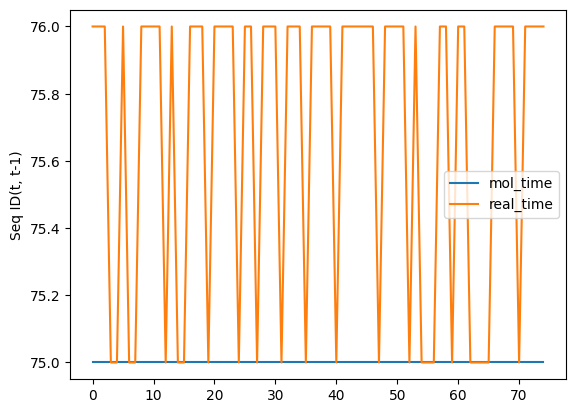

In [29]:
d_mol = [get_seqid(trajs_mol[2][i],trajs_mol[2][i-1]).item() for i in range(1,trajs_mol[2].shape[0])] 
d_real = [get_seqid(trajs_real[2][i],trajs_real[2][i-1]).item() for i in range(1,trajs_real[2].shape[0])] 

plt.plot(d_mol, label = "mol_time")
plt.plot(d_real, label = "real_time")
plt.legend()
plt.ylabel("Seq ID(t, t-1)")
plt.show()

In [40]:
trajs_mol[2].shape

torch.Size([76, 76, 21])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


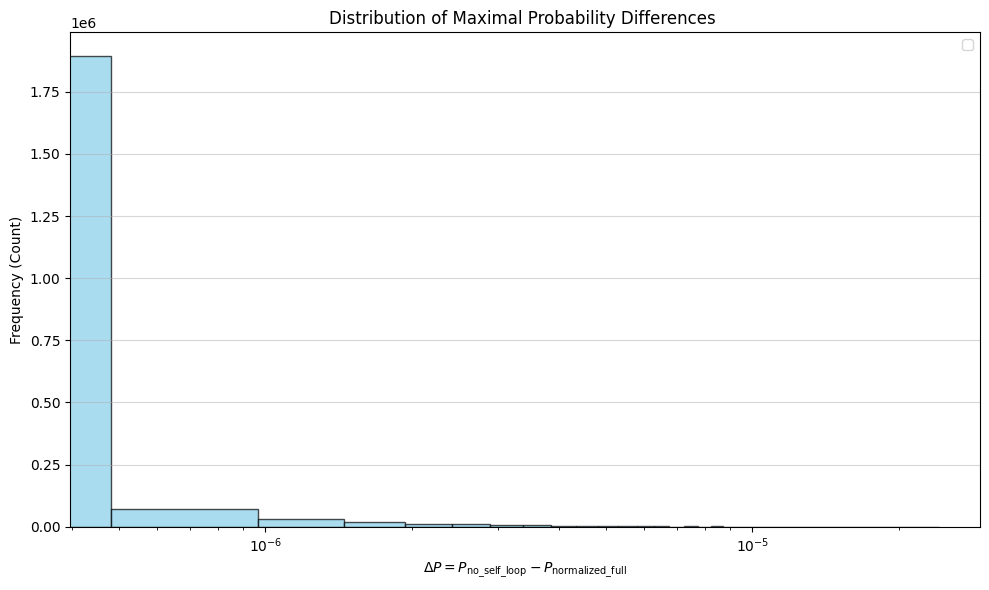

In [125]:



diff_p = []


for n in range(len(trajs_mol)):
    pfull = compute_gibbs_probabilities(trajs_mol[n], params, beta=1.0, remove_self_loop=False)
    prenorm = compute_gibbs_probabilities(trajs_mol[n], params, beta=1.0, remove_self_loop=True)
    for site_idx in range(76):
        for time_idx in range(trajs_mol[n].shape[0]):
            actual_amino=trajs_mol[n][time_idx,site_idx,:].argmax() 
            norm_factor = (1-pfull[site_idx,time_idx,actual_amino])
            pfull[site_idx,time_idx,actual_amino] = 0
            diff = prenorm[site_idx,time_idx,:] - pfull[site_idx,time_idx,:]/norm_factor
            #print(pfull[site_idx,time_idx,actual_amino]/norm_factor)
            #print(prenorm[site_idx,time_idx,actual_amino])
            diff_p.append(diff.max().cpu())



# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(diff_p, bins = 50, color='skyblue', edgecolor='black', alpha=0.7, density = True)
plt.title(f'Distribution of Maximal Probability Differences ')
plt.xlabel(r'$\Delta P = P_{\text{no\_self\_loop}} - P_{\text{normalized\_full}}$')
plt.ylabel('Frequency (Count)')
plt.grid(axis='y', alpha=0.5)
plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

In [304]:
L = 76
q = 21
N_PC = L*q


NTRAJS_long = 10000
wt_msa = torch.stack([msa_oh[0] for idx in range(NTRAJS_long)], dim=0)
wt_msa.shape
TRAJ_length = 2

N_iter = 10

molec_time = False # True

forces = []
noises = []
displs = []
std_displs = []
ps_wt = []
muts = []

# Perform PCA on the one-hot encoded MSA data
pca = PCA(n_components=N_PC)  # Adjust the number of components as needed
nat_msa_proj = pca.fit_transform(nat_msa_flat)  # Project the data onto the principal components

for round in range(N_iter):
    trajs = torch.stack(simulate_gibbs_trajectories(wt_msa[0:NTRAJS_long], params, 
                                        num_sweeps=2, max_traj_len=TRAJ_length, beta=1.0, 
                                        molec_time = molec_time,device=device, dtype=dtype))
    #print(trajs.shape)
    muts_msa_oh = trajs[:,1,:,:]
    
    #print(muts_msa_oh.shape)
    # Flatten generated MSA for PCA
    muts_flat = muts_msa_oh.view(len(muts_msa_oh), -1).cpu().numpy()  # Flatten the L*q matrix for each sequence
    muts.append(muts_flat)
        # Project the generated sequences onto the same principal components
    muts_pc = torch.tensor(pca.transform(muts_flat)).to(device)
    #print(muts_pc.shape)
    del muts_flat
    p_wt = torch.tensor(compute_gibbs_probabilities(msa_oh[0].unsqueeze(0), params, beta=1.0, remove_self_loop=molec_time)).to(device)
    ps_wt.append(p_wt)
    #print(p_wt.shape)
    wt_dms_pc = torch.stack(generate_dms_and_project_batch_timed(trajs[0,0,:,:].unsqueeze(0), pca)).to(device).squeeze(0)
    del trajs
    #print(wt_dms_pc.shape)
    wt_dms_displ = wt_dms_pc[1:,:] - wt_dms_pc[0,:].unsqueeze(0)
    #print(wt_dms_displ.shape)
    dms_size, pc_comp = wt_dms_displ.shape
    L, _, Q = p_wt.shape
    M, N_pc = wt_dms_displ.shape

    # Calculate the numerator and denominator in place
    numerator = (wt_dms_displ.reshape(L, Q, N_pc) * p_wt.transpose(1, 2)).sum(dim=(0, 1))
    denominator = p_wt.transpose(1, 2).sum(dim=(0, 1))

    # Final weighted mean, keeping the unsqueeze(0) operation
    force = (numerator / denominator).unsqueeze(0)

    del numerator, denominator
       
    numerator2 = ((wt_dms_displ.reshape(L, Q, N_pc)**2) * p_wt.transpose(1, 2)).sum(dim=(0, 1))
    denominator2 = p_wt.transpose(1, 2).sum(dim=(0, 1))
    std_displ = ((numerator2 / denominator2).unsqueeze(0) - (force**2)).sqrt()
    
    del wt_dms_displ, numerator2, denominator2, p_wt

    displ = muts_pc - wt_dms_pc[0,:].unsqueeze(0)
    noise = displ - force

    noises.append(noise)
    forces.append(force)
    displs.append(displ)
    std_displs.append(std_displ)

    del noise, displ
    del muts_msa_oh, std_displ, muts_pc

noises = torch.vstack(noises)
forces = torch.vstack(forces)
displs = torch.vstack(displs)
std_displs = torch.vstack(std_displs)
ps_wt = torch.stack(ps_wt)
muts = np.vstack(muts)


/tmp/ipykernel_527007/1937910442.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_wt = torch.tensor(compute_gibbs_probabilities(msa_oh[0].unsqueeze(0), params, beta=1.0, remove_self_loop=molec_time)).to(device)
/tmp/ipykernel_527007/1937910442.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_wt = torch.tensor(compute_gibbs_probabilities(msa_oh[0].unsqueeze(0), params, beta=1.0, remove_self_loop=molec_time)).to(device)
/tmp/ipykernel_527007/1937910442.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_wt = torch.tensor(comp

KeyboardInterrupt: 

In [ ]:
diff = (new_muts - wt.unsqueeze(0)).relu()  # for each new_sequence it puts 1 in site and amino of mutation
sim_p = diff.mean(dim=0)


tensor(100000.)

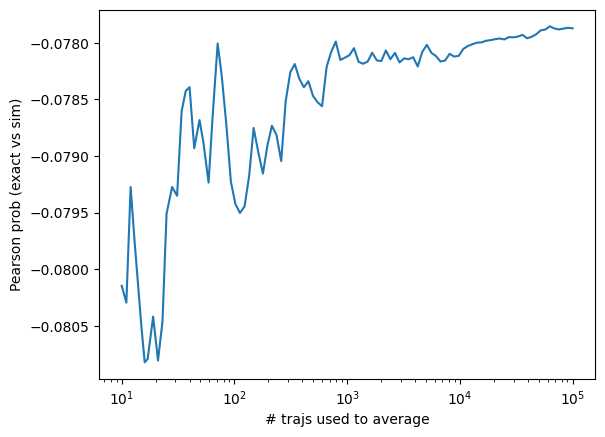

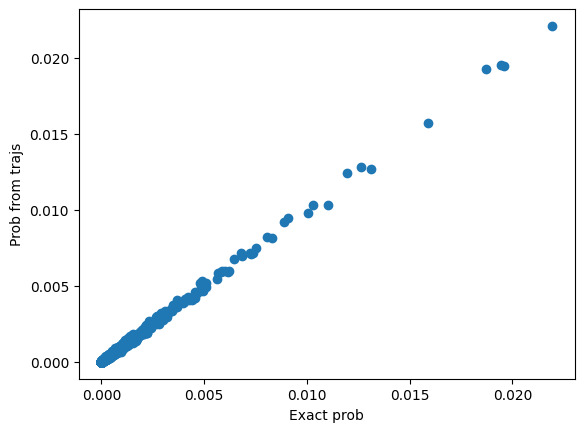

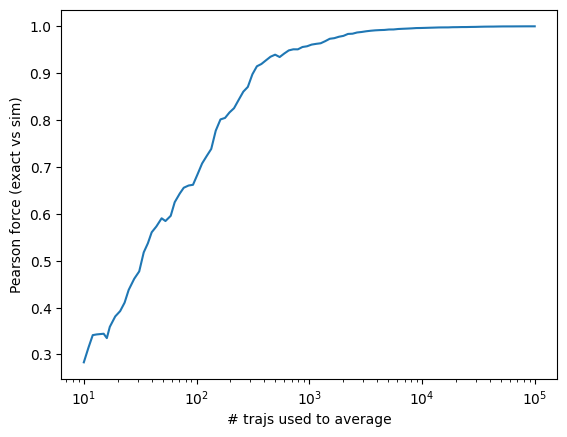

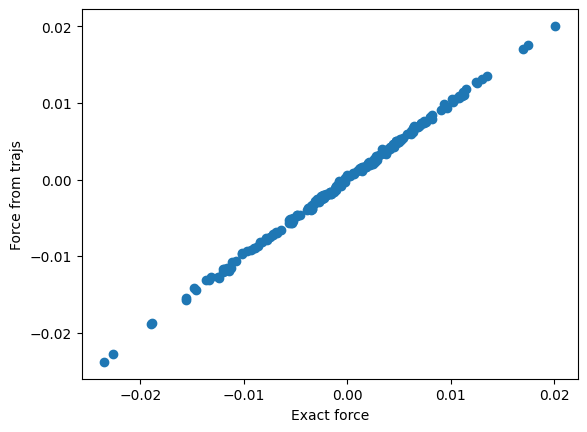

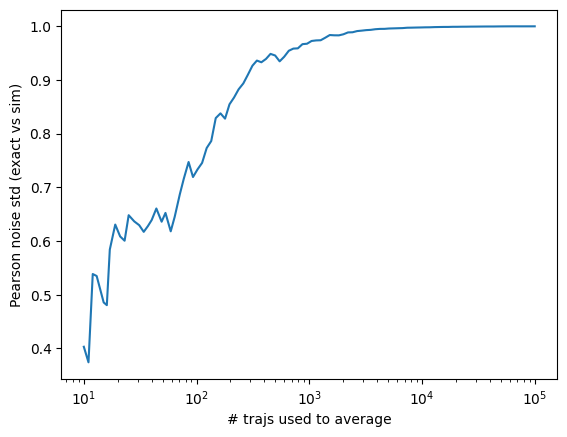

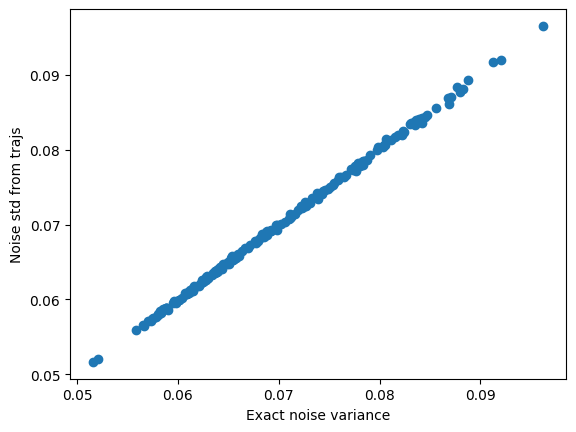

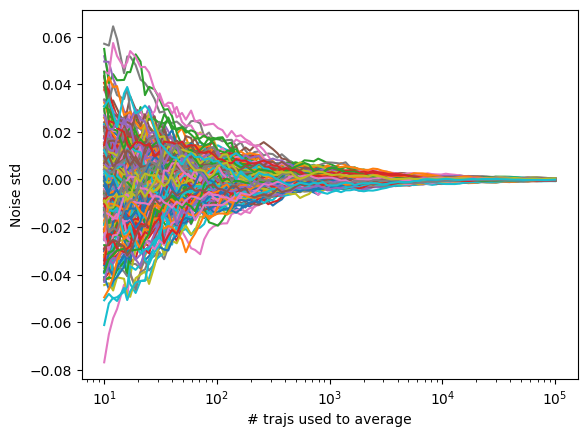

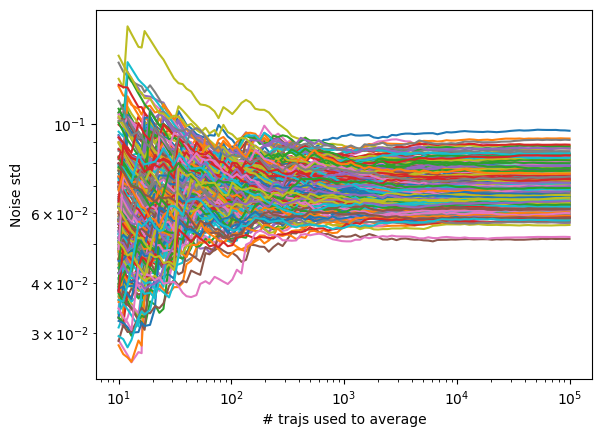

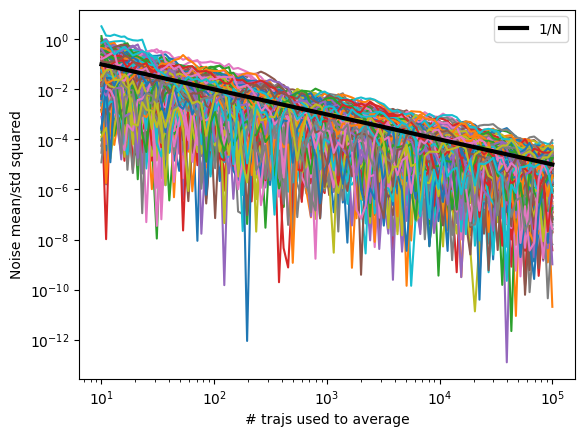

In [171]:

N_repl = NTRAJS_long * N_iter
N_pc_vis = 200


# Calculate the start and end of the exponent range (log base 10)
log_start = torch.log10(torch.tensor(10.0)) # log10(10) = 1.0
log_end = torch.log10(torch.tensor(N_repl, dtype=torch.float32))

# Generate the tensor 'sizes'
sizes = torch.logspace(
    start=log_start,
    end=log_end,
    steps=100,
    base=10.0 # Default base for logspace is 10, but good practice to be explicit
).round().int()

plt.plot(sizes, [pearson_correlation_1d(torch.tensor(muts[:i,:]).mean(dim=0).to("cpu"), ps_wt[0].squeeze(2).flatten().to("cpu")).cpu() for i in sizes])
plt.ylabel("Pearson prob (exact vs sim)")
plt.xlabel("# trajs used to average")
plt.xscale("log")
plt.show()

plt.scatter(sim_p.flatten(), ps_wt[0].squeeze(2).flatten().to("cpu"))
plt.xlabel("Exact prob")
plt.ylabel("Prob from trajs")
plt.show()

plt.plot(sizes, [pearson_correlation_1d(displs[:i,:N_pc_vis].mean(dim=0), forces[0,:N_pc_vis]).cpu() for i in sizes])
plt.ylabel("Pearson force (exact vs sim)")
plt.xlabel("# trajs used to average")
plt.xscale("log")
plt.show()

plt.scatter(displs[:,:N_pc_vis].mean(dim=0).cpu(), forces[0,:N_pc_vis].cpu())
plt.xlabel("Exact force")
plt.ylabel("Force from trajs")
plt.show()

plt.plot(sizes, [pearson_correlation_1d(displs[:i,:N_pc_vis].std(dim=0), std_displs[0,:N_pc_vis]).cpu() for i in sizes])
plt.ylabel("Pearson noise std (exact vs sim)")
plt.xlabel("# trajs used to average")
plt.xscale("log")
plt.show()

plt.scatter(displs[:,:N_pc_vis].std(dim=0).cpu(), std_displs[0,:N_pc_vis].cpu())
#plt.plot()
plt.xlabel("Exact noise variance")
plt.ylabel("Noise std from trajs")
plt.show()


y_mol = torch.stack([noises[:i,:N_pc_vis].mean(dim=0) for i in sizes])
std_mol = torch.stack([noises[:i,:N_pc_vis].std(dim=0) for i in sizes])

plt.plot(sizes, y_mol.cpu())
#plt.plot(y_real[:,0,:].cpu(), color = 'red')
plt.xscale("log")
plt.xlabel("# trajs used to average")
plt.ylabel("Noise std")
plt.show()



plt.plot(sizes,std_mol.cpu())
#plt.plot(sizes,[1/i for i in sizes], color = "black", linewidth = 3.)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Noise std")
plt.xlabel("# trajs used to average")
plt.show()



plt.plot(sizes, (y_mol.cpu()/ std_mol.cpu())**2)
plt.plot(sizes,[1/(i) for i in sizes], color = "black", linewidth = 3., label = "1/N")

plt.xscale("log")
plt.ylabel("Noise mean/std squared")
plt.xlabel("# trajs used to average")
plt.yscale("log")
plt.legend()
plt.show()


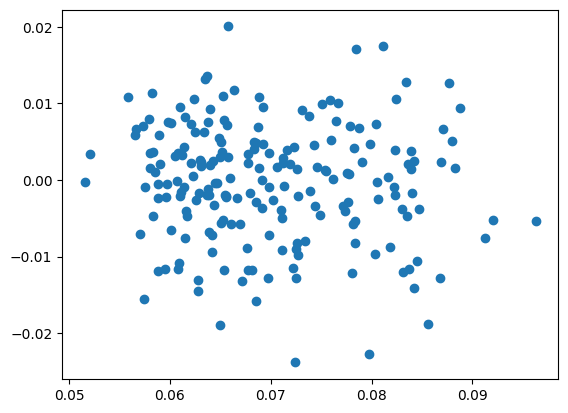

In [172]:
plt.scatter(noises[:,:200].std(dim=0).cpu(), forces[0,:200].cpu())

## Simulating trajectories

In [34]:

params = load_params("../data/DBD_full/params.dat", tokens=tokens, device=device, dtype=dtype)

# --- Load natural MSA ---
nat_fasta = f"../data/DBD_alignment.uniref90.cov80.nodupl.fasta"
nat_headers, nat_sequences = import_from_fasta(nat_fasta, tokens=tokens, filter_sequences=True)

# Convert to tensor (sequences should be one-hot encoded)
nat_msa_enc = torch.tensor(nat_sequences, device=device, dtype=torch.int32)

# One-hot encode the sequences
nat_msa_oh = one_hot(nat_msa_enc, num_classes=len(tokens)).to(dtype)

# Flatten MSA for PCA (L, q components)
L, q = nat_msa_oh.shape[1], nat_msa_oh.shape[2]  # L: sequence length, q: number of residues
nat_msa_flat = nat_msa_oh.view(len(nat_msa_oh), -1).cpu().numpy()  # Flatten the L*q matrix for each sequence


# --- Load generated MSA ---
generated_fasta = f"../data/DBD_full/sampling_samples.fasta"
headers, sequences = import_from_fasta(generated_fasta, tokens=tokens, filter_sequences=True)

# Convert to tensor (sequences should be one-hot encoded)
msa_enc = torch.tensor(sequences, device=device, dtype=torch.int32)

# One-hot encode the sequences
msa_oh = one_hot(msa_enc, num_classes=len(tokens)).to(dtype)

# Flatten generated MSA for PCA
msa_flat = msa_oh.view(len(msa_oh), -1).cpu().numpy()  # Flatten the L*q matrix for each sequence


_,L,q = msa_oh.shape 

N_pc = L*q

pca = PCA(n_components=N_pc)  # Adjust the number of components as needed
nat_msa_proj = pca.fit_transform(nat_msa_flat)  # Project the data onto the principal components


In [12]:
M = 10
T = 10 #(msa_oh.shape[1])+1
beta_eq = 1.0
beta_high = 4.0
beta_low = 0.25
molec_time=True
suffix = "mol_time" if molec_time else "real_time"
suffix


'mol_time'

In [13]:
# M, T, L, q
trajs_Teq = torch.stack(simulate_gibbs_trajectories(msa_oh[0:M], params, num_sweeps=50, molec_time=molec_time,
                                                    max_traj_len=T, beta=beta_eq, device=device, dtype=dtype)).to(device)
# M, L, T, q
gibbs_Teq = torch.stack([compute_gibbs_probabilities(trajs_Teq[i], params, beta=beta_eq, remove_self_loop=molec_time) 
            for i in range(M)]).to(device)


# M, T, L, q
trajs_Tlow = torch.stack(simulate_gibbs_trajectories(msa_oh[0:M], params, num_sweeps=50, molec_time=molec_time,
                                                    max_traj_len=T, beta=beta_high, device=device, dtype=dtype)).to(device)
# M, L, T, q
gibbs_Tlow = torch.stack([compute_gibbs_probabilities(trajs_Tlow[i], params, beta=beta_high, remove_self_loop=molec_time) 
            for i in range(M)]).to(device)


# M, T, L, q
trajs_Thigh = torch.stack(simulate_gibbs_trajectories(msa_oh[0:M], params, num_sweeps=50, molec_time=molec_time,
                                                    max_traj_len=T, beta=beta_low, device=device, dtype=dtype)).to(device)
# M, L, T, q
gibbs_Thigh = torch.stack([compute_gibbs_probabilities(trajs_Thigh[i], params, beta=beta_low, remove_self_loop=molec_time) 
            for i in range(M)]).to(device)

In [14]:
f_Teq, n_Teq, displ_Teq, pcs_Teq = calculate_forces_and_noises(trajs_Teq, gibbs_Teq, pca, device)
f_Tlow, n_Tlow, displ_Tlow, pcs_Tlow = calculate_forces_and_noises(trajs_Tlow, gibbs_Tlow, pca, device)
f_Thigh, n_Thigh, displ_Thigh, pcs_Thigh = calculate_forces_and_noises(trajs_Thigh, gibbs_Thigh, pca, device)


## Some images

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Enable LaTeX-style math font
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"


# -------------------------
# Correlation computation
# -------------------------
def compute_corr(data):
    M, T, _ = data.shape
    return torch.tensor([
        [pearson_correlation_1d(data[m, i, :], data[m, 0, :])
         for i in range(T-1)]
        for m in range(M)
    ])  # shape (M, T-1)


# -------------------------
# Plotting helper
# -------------------------
def plot_group(ax, corr, color, label):
    corr_np = corr.numpy()
    M, steps = corr_np.shape

    # faint individual curves (increased alpha)
    for m in range(M):
        ax.plot(corr_np[m], color=color, alpha=0.05, linewidth=1)

    # mean curve (slightly smoothed)
    mean = corr_np.mean(axis=0)

    ax.plot(mean, color=color, linewidth=2.5, label=label)




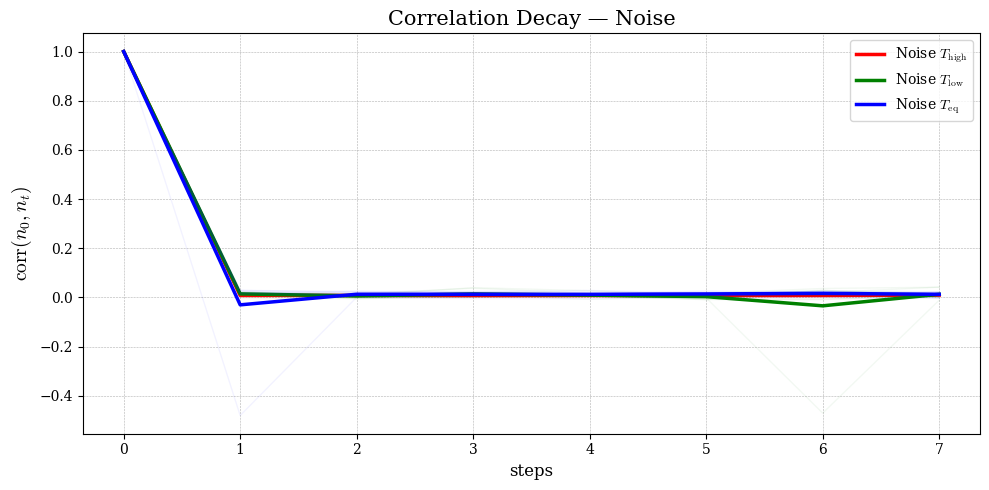

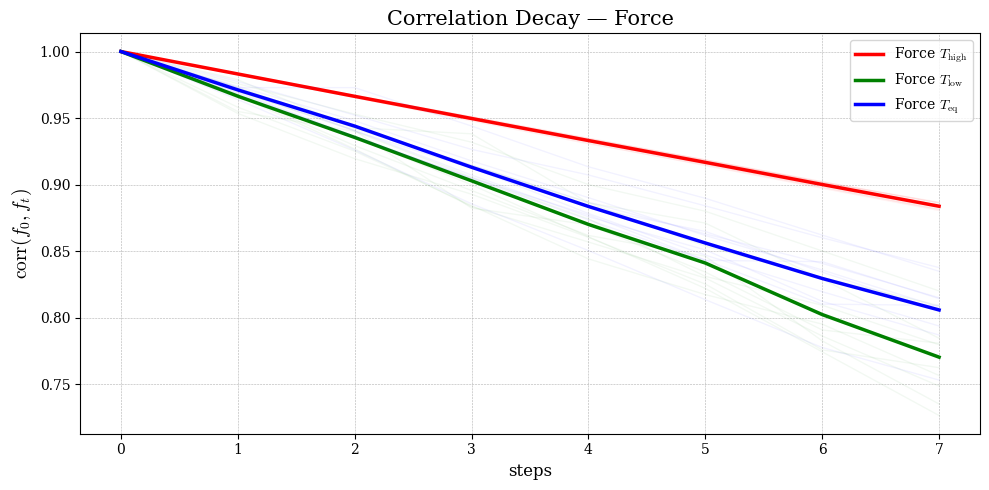

In [16]:
# ============================================================
#  NOISE correlations (n_Thigh, n_Tlow, n_Teq)
# ============================================================

corr_n_high = compute_corr(n_Thigh)
corr_n_low  = compute_corr(n_Tlow)
corr_n_eq   = compute_corr(n_Teq)

fig, ax = plt.subplots(figsize=(10, 5))

plot_group(ax, corr_n_high, color="red",   label="Noise $T_{\\text{high}}$")
plot_group(ax, corr_n_low,  color="green", label="Noise $T_{\\text{low}}$")
plot_group(ax, corr_n_eq,   color="blue",  label="Noise $T_{\\text{eq}}$")

ax.set_xlabel("steps", fontsize=12)
ax.set_ylabel(r"$\mathrm{corr}(n_0, n_t)$", fontsize=14)
ax.set_title(r"Correlation Decay — Noise", fontsize=15)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/acn_{suffix}.png")
plt.show()


# ============================================================
#  FORCE correlations (f_Thigh, f_Tlow, f_Teq)
# ============================================================

corr_f_high = compute_corr(f_Thigh)
corr_f_low  = compute_corr(f_Tlow)
corr_f_eq   = compute_corr(f_Teq)

fig, ax = plt.subplots(figsize=(10, 5))

plot_group(ax, corr_f_high, color="red",   label="Force $T_{\\text{high}}$")
plot_group(ax, corr_f_low,  color="green", label="Force $T_{\\text{low}}$")
plot_group(ax, corr_f_eq,   color="blue",  label="Force $T_{\\text{eq}}$")

ax.set_xlabel("steps", fontsize=12)
ax.set_ylabel(r"$\mathrm{corr}(f_0, f_t)$", fontsize=14)
ax.set_title(r"Correlation Decay — Force", fontsize=15)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/acf_{suffix}.png")
plt.show()


In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Enable LaTeX-style fonts
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"




# -------------------------------------------------------
# Plotting helper
# -------------------------------------------------------
def plot_group(ax, data, color, label):
    data_np = data.numpy()
    M, steps = data_np.shape

    # Individual curves (higher alpha)
    for m in range(M):
        ax.plot(data_np[m], color=color, alpha=0.025, linewidth=1)

    # Smoothed mean curve
    mean = data_np.mean(axis=0)
    

    ax.plot(mean, color=color, linewidth=2.5, label=label)




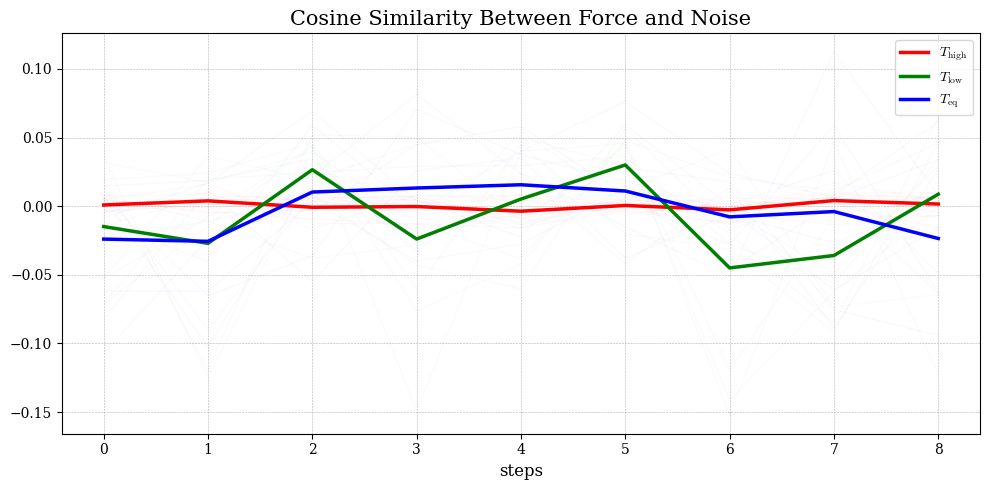

In [18]:
# =======================================================
#  COSINE SIMILARITY: Noise vs Force at each time
# =======================================================

# Thigh, Tlow, Teq
cos_high = compute_cosine_curve(f_Thigh, n_Thigh)
cos_low  = compute_cosine_curve(f_Tlow,  n_Tlow)
cos_eq   = compute_cosine_curve(f_Teq,   n_Teq)


# =======================================================
#  Plot
# =======================================================

fig, ax = plt.subplots(figsize=(10, 5))

plot_group(ax, cos_high, color="red",   label=r"$T_{\text{high}}$")
plot_group(ax, cos_low,  color="green", label=r"$T_{\text{low}}$")
plot_group(ax, cos_eq,   color="blue",  label=r"$T_{\text{eq}}$")

ax.set_xlabel("steps", fontsize=12)
ax.set_title("Cosine Similarity Between Force and Noise", fontsize=15)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()
plt.savefig(f"../figures/cos_sim_{suffix}.png")
plt.tight_layout()
plt.show()


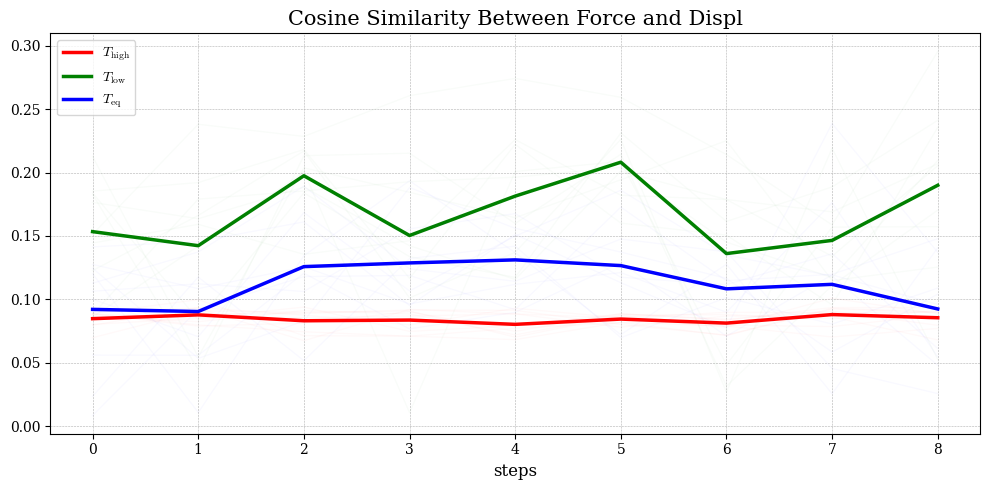

In [19]:
# =======================================================
#  COSINE SIMILARITY: Noise vs Force at each time
# =======================================================

# Thigh, Tlow, Teq
cos_high = compute_cosine_curve(f_Thigh, displ_Thigh)
cos_low  = compute_cosine_curve(f_Tlow,  displ_Tlow)
cos_eq   = compute_cosine_curve(f_Teq,   displ_Teq)


# =======================================================
#  Plot
# =======================================================

fig, ax = plt.subplots(figsize=(10, 5))

plot_group(ax, cos_high, color="red",   label=r"$T_{\text{high}}$")
plot_group(ax, cos_low,  color="green", label=r"$T_{\text{low}}$")
plot_group(ax, cos_eq,   color="blue",  label=r"$T_{\text{eq}}$")

ax.set_xlabel("steps", fontsize=12)
ax.set_title("Cosine Similarity Between Force and Displ", fontsize=15)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()
plt.savefig(f"../figures/cos_sim_force_displ{suffix}.png")
plt.tight_layout()
plt.show()


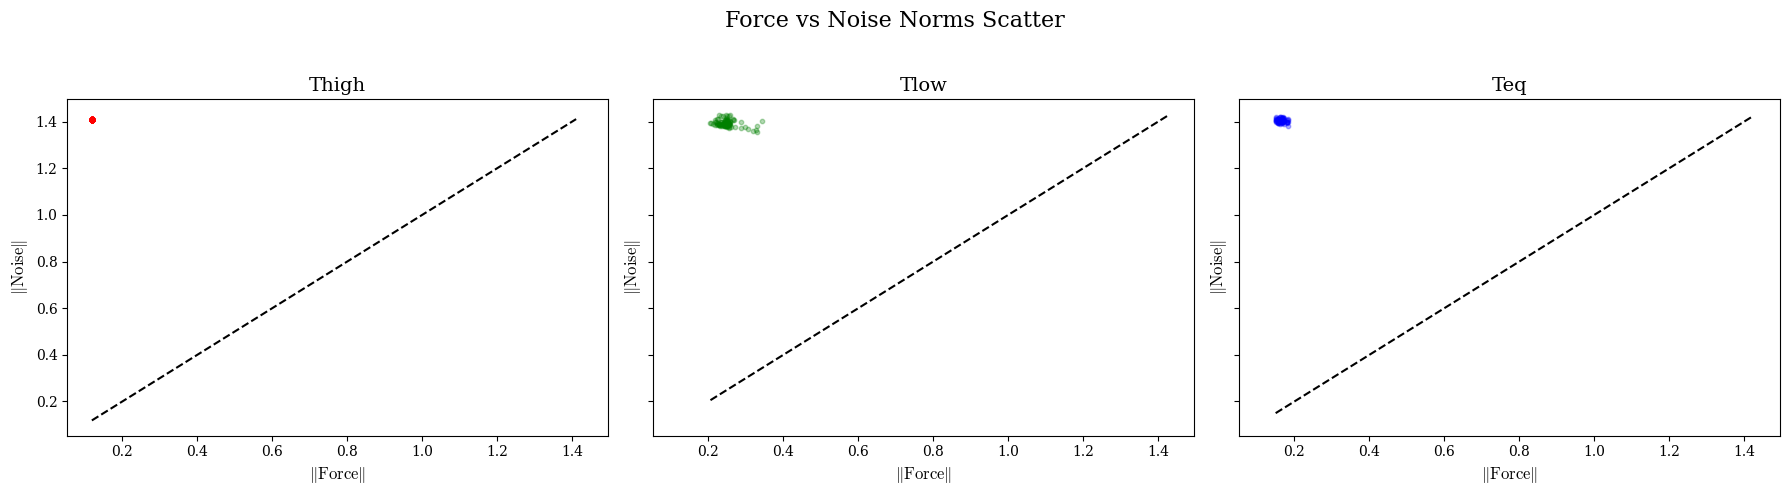

In [20]:
import torch
import matplotlib.pyplot as plt

# Enable LaTeX-style fonts
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"

# -----------------------------
# Prepare datasets
# -----------------------------
datasets = [
    ("Thigh", f_Thigh, n_Thigh, "red"),
    ("Tlow",  f_Tlow,  n_Tlow,  "green"),
    ("Teq",   f_Teq,   n_Teq,   "blue")
]

# -----------------------------
# Create subplots
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, (label, f_data, n_data, color) in zip(axes, datasets):
    # Compute norms for each trajectory and time
    f_norm = torch.norm(f_data, dim=-1).flatten().cpu()
    n_norm = torch.norm(n_data, dim=-1).flatten().cpu()
    
    # Scatter plot with transparency
    ax.scatter(f_norm, n_norm, color=color, alpha=0.3, s=10)
    
    # Diagonal line y=x
    min_val = min(f_norm.min(), n_norm.min())
    max_val = max(f_norm.max(), n_norm.max())
    ax.plot([min_val, max_val], [min_val, max_val], color="black", linestyle="--")
    
    # Labels and title
    ax.set_xlabel(r"$\| \mathrm{Force} \|$", fontsize=12)
    ax.set_ylabel(r"$\| \mathrm{Noise} \|$", fontsize=12)
    ax.set_title(label, fontsize=14)

# Global title
plt.suptitle("Force vs Noise Norms Scatter", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"../figures/noise_vs_force_{suffix}.png")
plt.show()



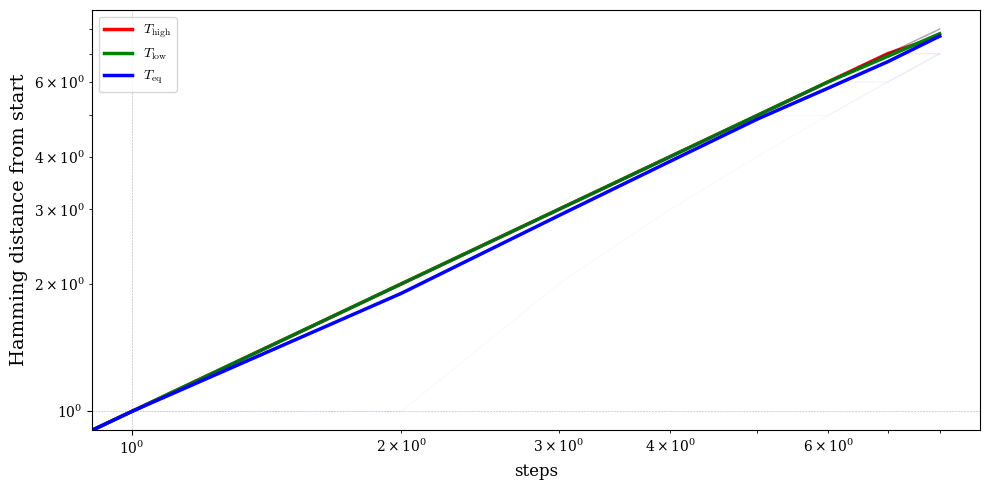

In [21]:
d_Teq = torch.stack([get_seqid(trajs_Teq[:,0,:,:], trajs_Teq[:,i,:,:]) for i in range(T-1)]).T
d_Thigh = torch.stack([get_seqid(trajs_Thigh[:,0,:,:], trajs_Thigh[:,i,:,:]) for i in range(T-1)]).T
d_Tlow = torch.stack([get_seqid(trajs_Tlow[:,0,:,:], trajs_Tlow[:,i,:,:]) for i in range(T-1)]).T

ig, ax = plt.subplots(figsize=(10, 5))

plot_group(ax, 76 - d_Thigh.cpu(), color="red",   label="$T_{\\text{high}}$")
plot_group(ax, 76 - d_Tlow.cpu(),  color="green", label="$T_{\\text{low}}$")
plot_group(ax, 76 - d_Teq.cpu(),   color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("steps", fontsize=12)
ax.set_ylabel(r"Hamming distance from start", fontsize=14)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/seqid_{suffix}.png")
plt.show()


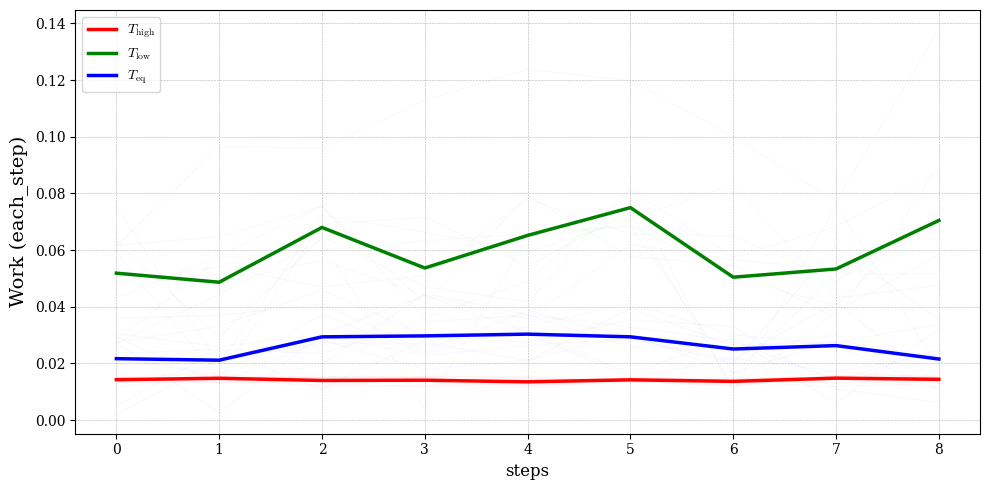

In [22]:
ig, ax = plt.subplots(figsize=(10, 5))

plot_group(ax, (f_Thigh*displ_Thigh).sum(dim=2).cpu(), color="red",   label="$T_{\\text{high}}$")
plot_group(ax, (f_Tlow*displ_Tlow).sum(dim=2).cpu(),  color="green", label="$T_{\\text{low}}$")
plot_group(ax, (f_Teq*displ_Teq).sum(dim=2).cpu(),   color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("steps", fontsize=12)
ax.set_ylabel(r"Work (each_step)", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/work_each_step_{suffix}.png")
plt.show()

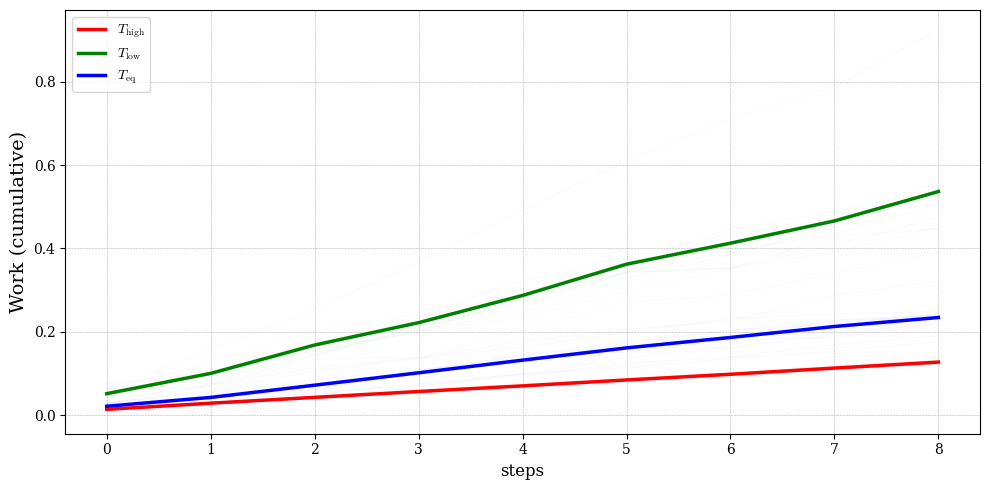

In [23]:
ig, ax = plt.subplots(figsize=(10, 5))

plot_group(ax, (f_Thigh*displ_Thigh).sum(dim=2).cumsum(dim=1).cpu(), color="red",   label="$T_{\\text{high}}$")
plot_group(ax, (f_Tlow*displ_Tlow).sum(dim=2).cumsum(dim=1).cpu(),  color="green", label="$T_{\\text{low}}$")
plot_group(ax, (f_Teq*displ_Teq).sum(dim=2).cumsum(dim=1).cpu(),   color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("steps", fontsize=12)
ax.set_ylabel(r"Work (cumulative)", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/work_cumulative_{suffix}.png")
plt.show()

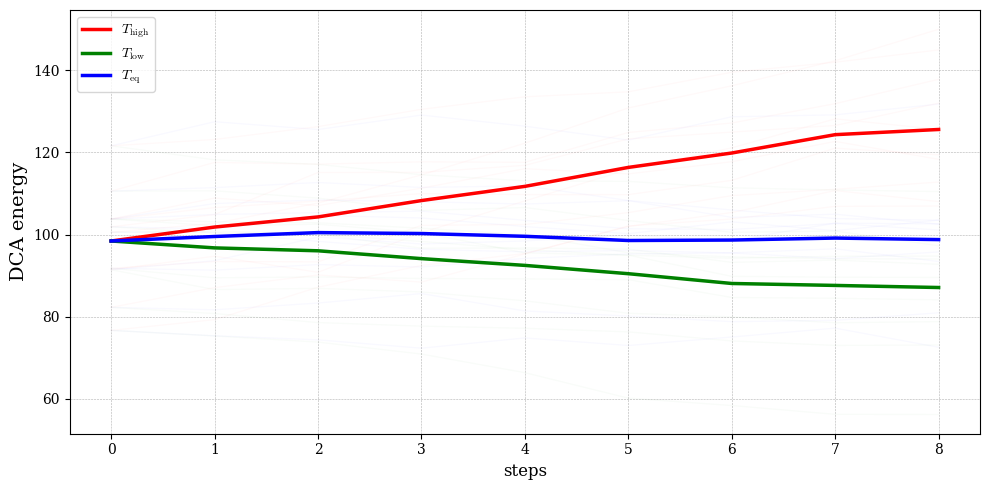

In [24]:
en_Teq = torch.stack([compute_energy(trajs_Teq[:,i,:,:], params) for i in range(T-1)]).T
en_Thigh = torch.stack([compute_energy(trajs_Thigh[:,i,:,:], params) for i in range(T-1)]).T
en_Tlow = torch.stack([compute_energy(trajs_Tlow[:,i,:,:], params) for i in range(T-1)]).T

ig, ax = plt.subplots(figsize=(10, 5))

plot_group(ax, en_Thigh.cpu(), color="red",   label="$T_{\\text{high}}$")
plot_group(ax, en_Tlow.cpu(),  color="green", label="$T_{\\text{low}}$")
plot_group(ax, en_Teq.cpu(),   color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("steps", fontsize=12)
ax.set_ylabel(r"DCA energy", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/en_{suffix}.png")
plt.show()

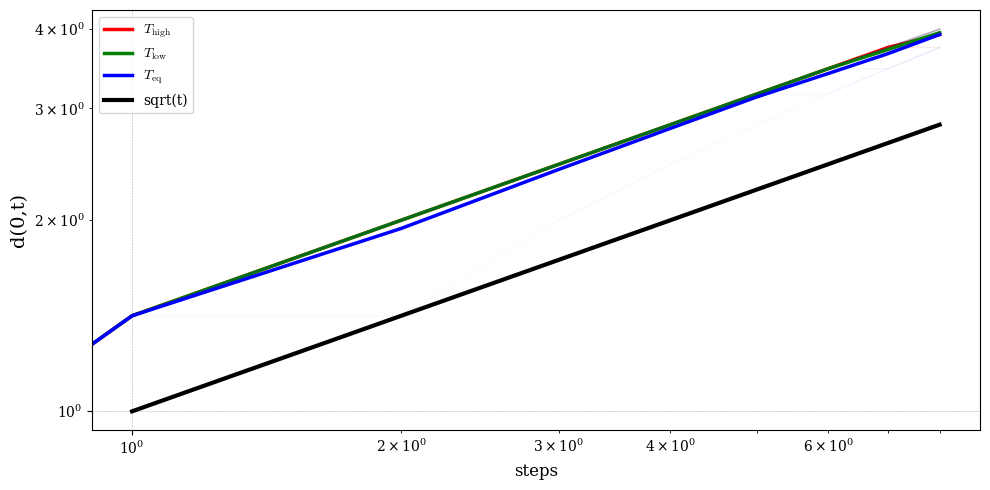

In [27]:
dpca_Teq = torch.sqrt(torch.stack([((pcs_Teq[:,i,:] - pcs_Teq[:,0,:])**2).sum(dim=1) for i in range(T-1)]).mT)
dpca_Tlow = torch.sqrt(torch.stack([((pcs_Tlow[:,i,:] - pcs_Tlow[:,0,:])**2).sum(dim=1) for i in range(T-1)]).mT)
dpca_Thigh = torch.sqrt(torch.stack([((pcs_Thigh[:,i,:] - pcs_Thigh[:,0,:])**2).sum(dim=1) for i in range(T-1)]).mT)

ig, ax = plt.subplots(figsize=(10, 5))

plot_group(ax, dpca_Thigh.cpu(), color="red",   label="$T_{\\text{high}}$")
plot_group(ax, dpca_Tlow.cpu(),  color="green", label="$T_{\\text{low}}$")
plot_group(ax, dpca_Teq.cpu(),   color="blue",  label="$T_{\\text{eq}}$")
ax.plot([i for i in range(1,T-1)], [(i)**0.5 for i in range(1,T-1)], color = "black", linewidth=3., label = "sqrt(t)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("steps", fontsize=12)
ax.set_ylabel(r"d(0,t)", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/dpca_{suffix}.png")
plt.show()

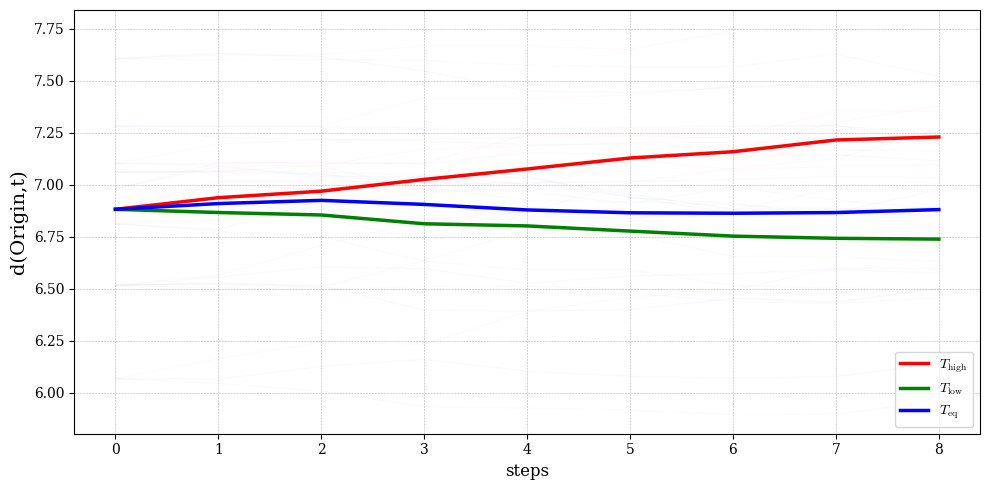

In [28]:
dorig_pca_Teq = torch.sqrt(torch.stack([((pcs_Teq[:,i,:])**2).sum(dim=1) for i in range(T-1)]).mT)
dorig_pca_Thigh = torch.sqrt(torch.stack([((pcs_Thigh[:,i,:])**2).sum(dim=1) for i in range(T-1)]).mT)
dorig_pca_Tlow = torch.sqrt(torch.stack([((pcs_Tlow[:,i,:])**2).sum(dim=1) for i in range(T-1)]).mT)


ig, ax = plt.subplots(figsize=(10, 5))

plot_group(ax, dorig_pca_Thigh.cpu(), color="red",   label="$T_{\\text{high}}$")
plot_group(ax, dorig_pca_Tlow.cpu(),  color="green", label="$T_{\\text{low}}$")
plot_group(ax, dorig_pca_Teq.cpu(),   color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("steps", fontsize=12)
ax.set_ylabel(r"d(Origin,t)", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/doriginpca_{suffix}.png")
plt.show()

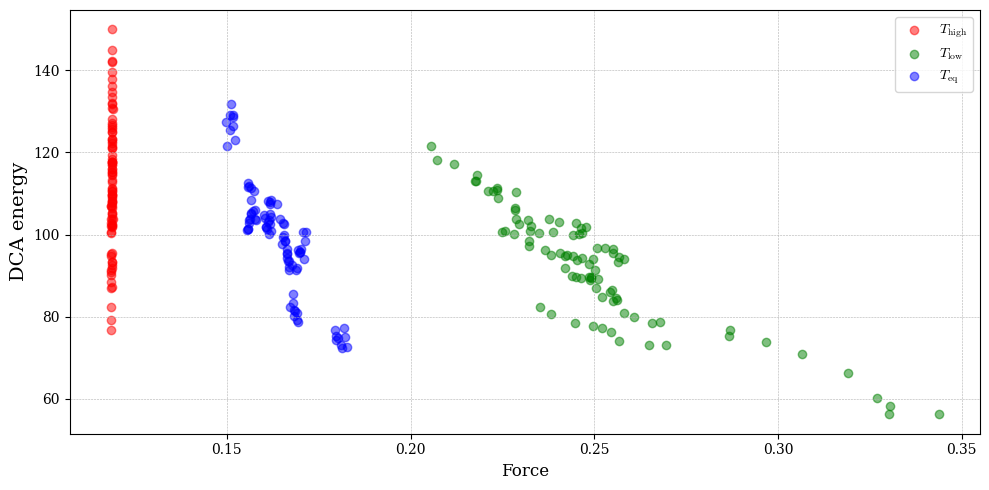

In [29]:
ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(f_Thigh.norm(dim=-1).cpu(), en_Thigh.cpu(), alpha = 0.5, color="red",   label="$T_{\\text{high}}$")
ax.scatter(f_Tlow.norm(dim=-1).cpu(), en_Tlow.cpu(), alpha = 0.5, color="green", label="$T_{\\text{low}}$")
ax.scatter(f_Teq.norm(dim=-1).cpu(), en_Teq.cpu(),  alpha = 0.5,  color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("Force", fontsize=12)
ax.set_ylabel(r"DCA energy", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/fvsenergy_{suffix}.png")
plt.show()



ValueError: x and y must be the same size

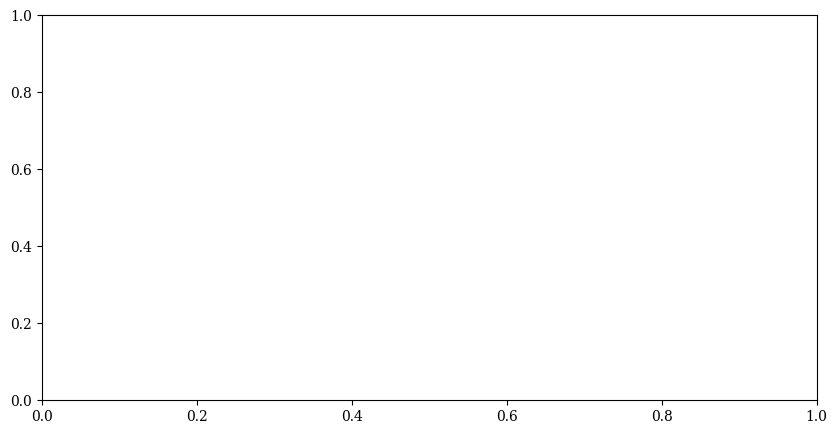

In [30]:

ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(f_Thigh[:, 0:75,:].norm(dim=-1).cpu(), en_Thigh.diff(dim=1).cpu(), alpha = 0.5, color="red",   label="$T_{\\text{high}}$")
ax.scatter(f_Tlow[:, 0:75,:].norm(dim=-1).cpu(), en_Tlow.diff(dim=1).cpu(), alpha = 0.5, color="green", label="$T_{\\text{low}}$")
ax.scatter(f_Teq[:, 0:75,:].norm(dim=-1).cpu(), en_Teq.diff(dim=1).cpu(),  alpha = 0.5,  color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("Force", fontsize=12)
ax.set_ylabel(r"DCA delta energy", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/fvsdeltaenergy_{suffix}.png")
plt.show()



ValueError: x and y must be the same size

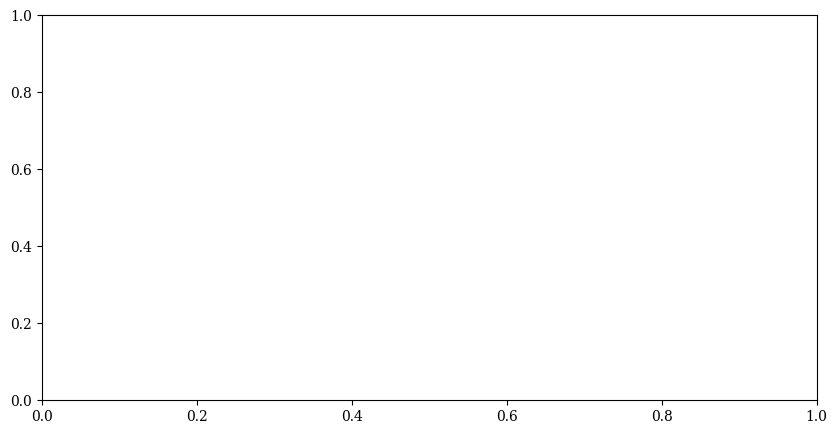

In [31]:

ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter((f_Thigh*displ_Thigh)[:,:75,:].sum(dim=2).cpu(), en_Thigh.diff(dim=1).cpu(), alpha = 0.5, color="red",   label="$T_{\\text{high}}$")
ax.scatter((f_Tlow*displ_Tlow)[:,:75,:].sum(dim=2).cpu(), en_Tlow.diff(dim=1).cpu(), alpha = 0.5, color="green", label="$T_{\\text{low}}$")
ax.scatter((f_Teq*displ_Teq)[:,:75,:].sum(dim=2).cpu(), en_Teq.diff(dim=1).cpu(),  alpha = 0.5,  color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("work", fontsize=12)
ax.set_ylabel(r"DCA delta energy", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/workvsenergy_{suffix}.png")
plt.show()


ValueError: x and y must be the same size

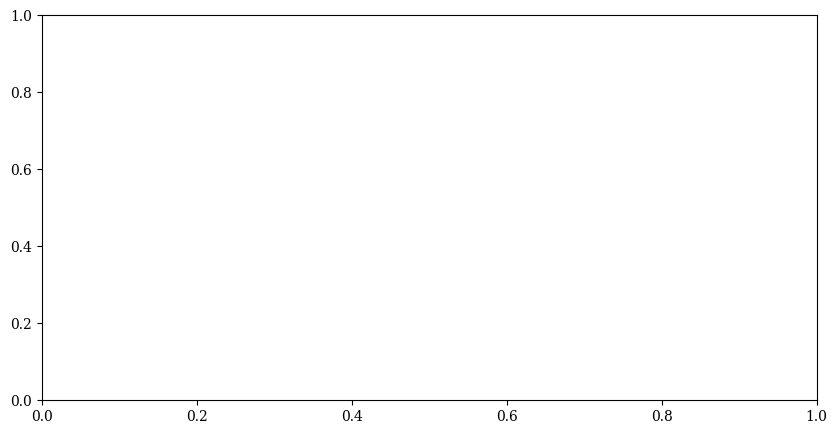

In [32]:
# Thigh, Tlow, Teq
cos_fdispl_high = compute_cosine_curve(f_Thigh, displ_Thigh)
cos_fdispl_low  = compute_cosine_curve(f_Tlow,  displ_Tlow)
cos_fdispl_eq   = compute_cosine_curve(f_Teq,   displ_Teq)


g, ax = plt.subplots(figsize=(10, 5))

ax.scatter(cos_fdispl_high[:,:75], en_Thigh.diff(dim=1).cpu(), alpha = 0.5, color="red",   label="$T_{\\text{high}}$")
ax.scatter(cos_fdispl_low[:,:75], en_Tlow.diff(dim=1).cpu(), alpha = 0.5, color="green", label="$T_{\\text{low}}$")
ax.scatter(cos_fdispl_eq[:,:75], en_Teq.diff(dim=1).cpu(),  alpha = 0.5,  color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("Cosine similarity, force vs displ", fontsize=12)
ax.set_ylabel(r"DCA delta energy", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/cosfdisplvsenergy_{suffix}.png")
plt.show()



ValueError: x and y must be the same size

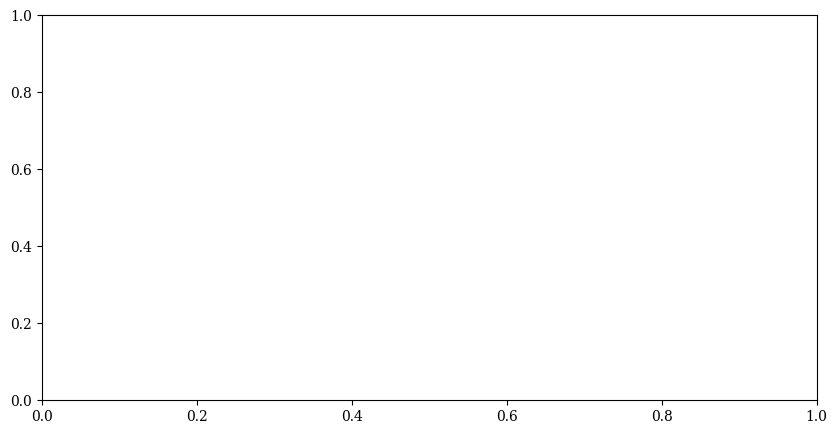

In [33]:
ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(n_Thigh[:, 0:75,:].norm(dim=-1).cpu(), en_Thigh.diff(dim=1).cpu(), alpha = 0.5, color="red",   label="$T_{\\text{high}}$")
ax.scatter(n_Tlow[:, 0:75,:].norm(dim=-1).cpu(), en_Tlow.diff(dim=1).cpu(), alpha = 0.5, color="green", label="$T_{\\text{low}}$")
ax.scatter(n_Teq[:, 0:75,:].norm(dim=-1).cpu(), en_Teq.diff(dim=1).cpu(),  alpha = 0.5,  color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("Noise", fontsize=12)
ax.set_ylabel(r"DCA delta energy", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()
plt.tight_layout()
plt.savefig(f"../figures/noisevsdeltaenergy_{suffix}.png")
plt.show()


## Continuity of force

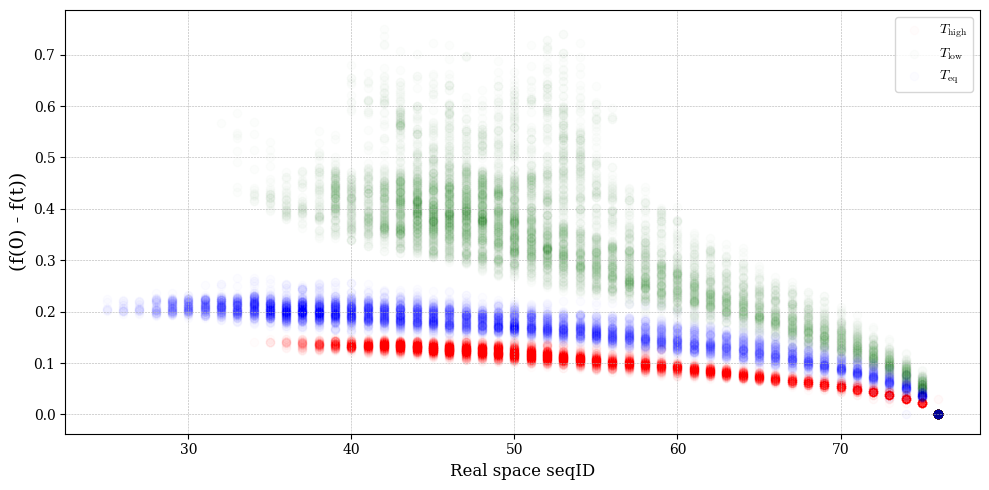

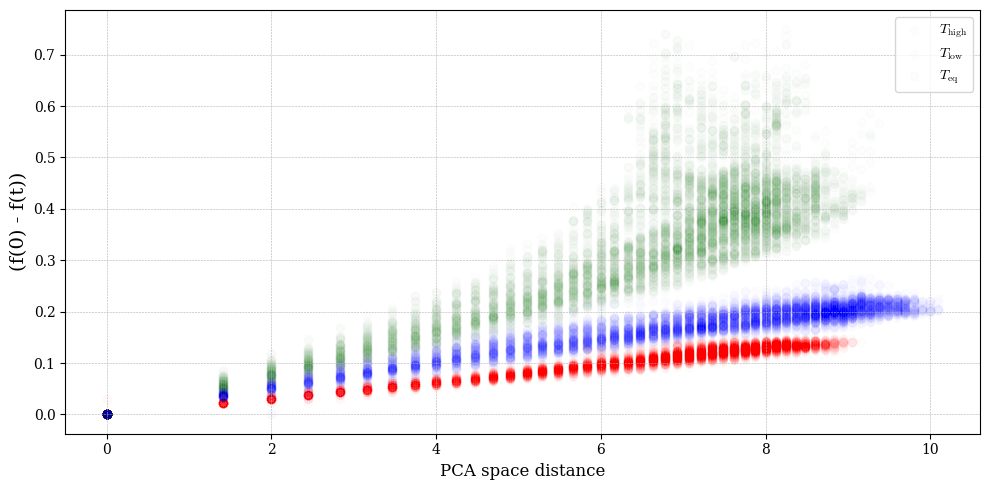

In [95]:
df_Teq = torch.sqrt(torch.stack([((f_Teq[:,i,:] - f_Teq[:,0,:])**2).sum(dim=1) for i in range(T-1)]).mT)
df_Tlow = torch.sqrt(torch.stack([((f_Tlow[:,i,:] - f_Tlow[:,0,:])**2).sum(dim=1) for i in range(T-1)]).mT)
df_Thigh = torch.sqrt(torch.stack([((f_Thigh[:,i,:] - f_Thigh[:,0,:])**2).sum(dim=1) for i in range(T-1)]).mT)

ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(d_Teq.cpu(), df_Thigh.cpu(), alpha = 0.01, color="red",   label="$T_{\\text{high}}$")
ax.scatter(d_Tlow.cpu(), df_Tlow.cpu(), alpha = 0.01, color="green", label="$T_{\\text{low}}$")
ax.scatter(d_Thigh.cpu(), df_Teq.cpu(),  alpha = 0.01,  color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("Real space seqID", fontsize=12)
ax.set_ylabel(r"(f(0) - f(t))", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/df_seqID_{suffix}.png")
plt.show()


g, ax = plt.subplots(figsize=(10, 5))

ax.scatter(dpca_Teq.cpu(), df_Thigh.cpu(), alpha = 0.01, color="red",   label="$T_{\\text{high}}$")
ax.scatter(dpca_Tlow.cpu(), df_Tlow.cpu(),  alpha = 0.01, color="green", label="$T_{\\text{low}}$")
ax.scatter(dpca_Thigh.cpu(), df_Teq.cpu(),   alpha = 0.01, color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("PCA space distance", fontsize=12)
ax.set_ylabel(r"(f(0) - f(t))", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/df_pca_{suffix}.png")
plt.show()

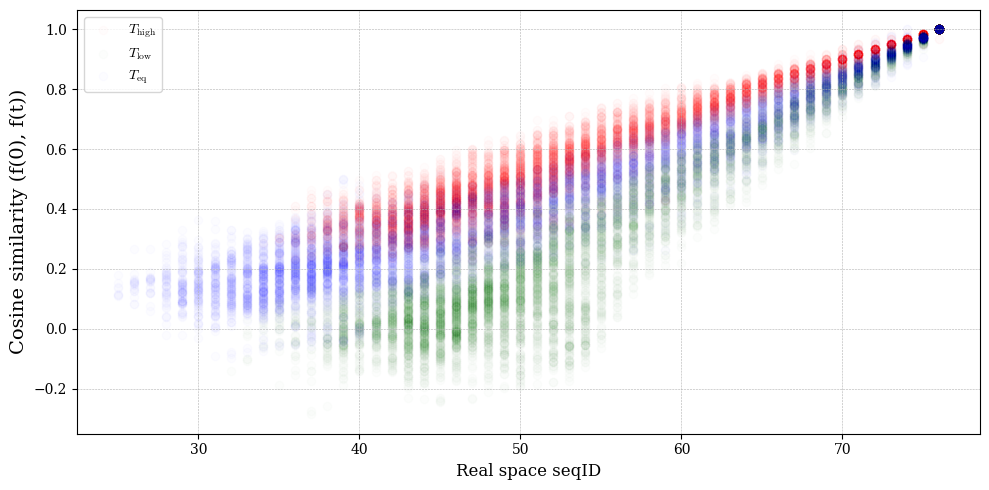

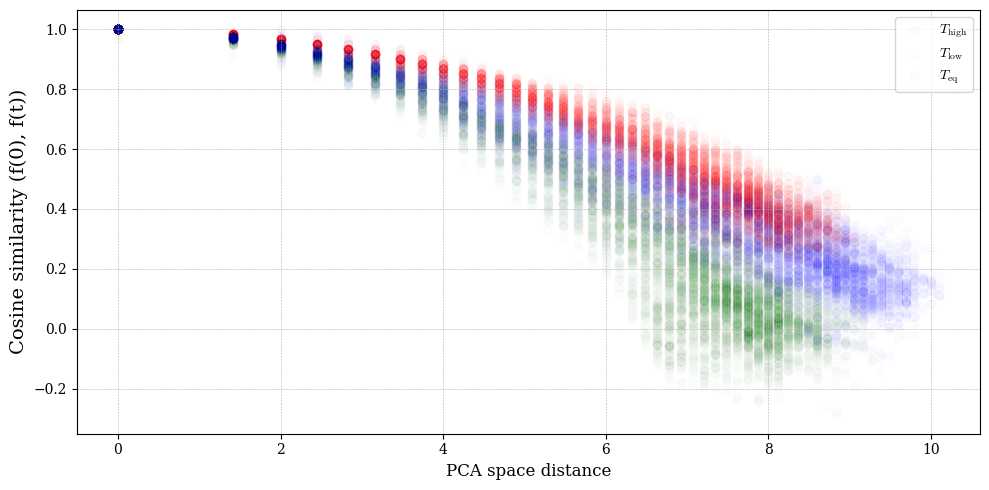

In [96]:
cosf_Teq = torch.tensor([[cosine_sim(f_Teq[m, i, :], f_Teq[m, 0, :]) for i in range(T-1)] for m in range(M)])
cosf_Thigh = torch.tensor([[cosine_sim(f_Thigh[m, i, :], f_Thigh[m, 0, :]) for i in range(T-1)] for m in range(M)])
cosf_Tlow = torch.tensor([[cosine_sim(f_Tlow[m, i, :], f_Tlow[m, 0, :]) for i in range(T-1)] for m in range(M)])

ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(d_Teq.cpu(), cosf_Thigh.cpu(), alpha = 0.01, color="red",   label="$T_{\\text{high}}$")
ax.scatter(d_Tlow.cpu(), cosf_Tlow.cpu(),  alpha = 0.01, color="green", label="$T_{\\text{low}}$")
ax.scatter(d_Thigh.cpu(), cosf_Teq.cpu(),   alpha = 0.01, color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("Real space seqID", fontsize=12)
ax.set_ylabel(r"Cosine similarity (f(0), f(t))", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/cosf_seqID_{suffix}.png")
plt.show()


g, ax = plt.subplots(figsize=(10, 5))

ax.scatter(dpca_Teq.cpu(), cosf_Thigh.cpu(), alpha = 0.01, color="red",   label="$T_{\\text{high}}$")
ax.scatter(dpca_Tlow.cpu(), cosf_Tlow.cpu(),  alpha = 0.01, color="green", label="$T_{\\text{low}}$")
ax.scatter(dpca_Thigh.cpu(), cosf_Teq.cpu(),   alpha = 0.01, color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("PCA space distance", fontsize=12)
ax.set_ylabel(r"Cosine similarity (f(0), f(t))", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/cosf_pca_{suffix}.png")
plt.show()

In [323]:
succ_d_Teq = torch.stack([get_seqid(trajs_Teq[:,i+1,:,:], trajs_Teq[:,i,:,:]) for i in range(T-2)]).T
succ_d_Thigh = torch.stack([get_seqid(trajs_Thigh[:,i+1,:,:], trajs_Thigh[:,i,:,:]) for i in range(T-2)]).T
succ_d_Tlow = torch.stack([get_seqid(trajs_Tlow[:,i+1,:,:], trajs_Tlow[:,i,:,:]) for i in range(T-2)]).T

succ_dpca_Teq = torch.sqrt(torch.stack([((pcs_Teq[:,i,:] - pcs_Teq[:,0,:])**2).sum(dim=1) for i in range(T-2)]).mT)
succ_dpca_Tlow = torch.sqrt(torch.stack([((pcs_Tlow[:,i,:] - pcs_Tlow[:,0,:])**2).sum(dim=1) for i in range(T-2)]).mT)
succ_dpca_Thigh = torch.sqrt(torch.stack([((pcs_Thigh[:,i,:] - pcs_Thigh[:,0,:])**2).sum(dim=1) for i in range(T-2)]).mT)

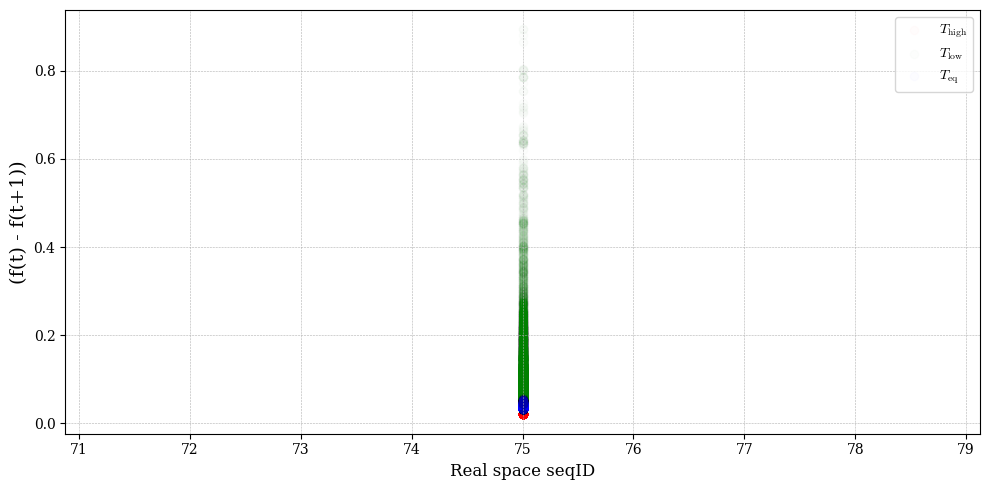

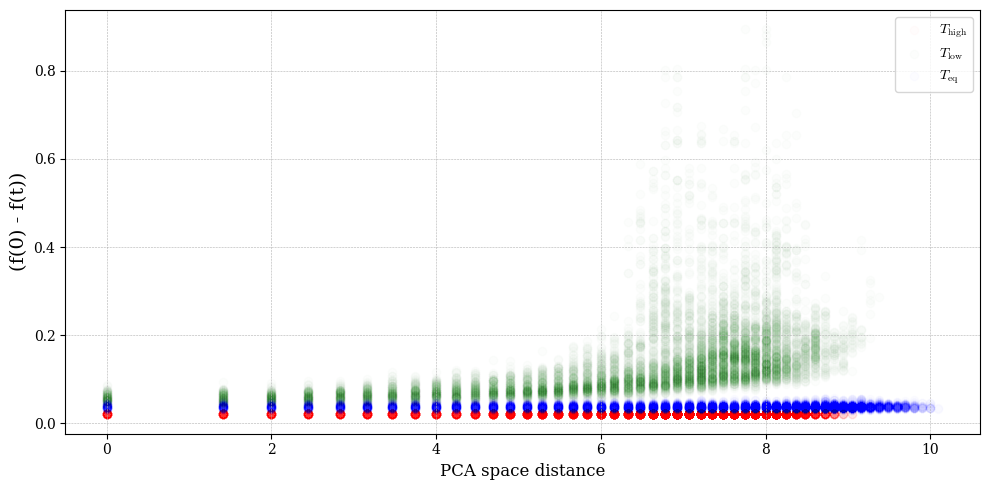

In [ ]:



succ_df_Teq = torch.sqrt(torch.stack([((f_Teq[:,i,:] - f_Teq[:,i+1,:])**2).sum(dim=1) for i in range(T-2)]).mT)
succ_df_Tlow = torch.sqrt(torch.stack([((f_Tlow[:,i,:] - f_Tlow[:,i+1,:])**2).sum(dim=1) for i in range(T-2)]).mT)
succ_df_Thigh = torch.sqrt(torch.stack([((f_Thigh[:,i,:] - f_Thigh[:,i+1,:])**2).sum(dim=1) for i in range(T-2)]).mT)

ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(succ_d_Teq.cpu(), succ_df_Thigh.cpu(), alpha = 0.01, color="red",   label="$T_{\\text{high}}$")
ax.scatter(succ_d_Tlow.cpu(), succ_df_Tlow.cpu(), alpha = 0.01, color="green", label="$T_{\\text{low}}$")
ax.scatter(succ_d_Thigh.cpu(), succ_df_Teq.cpu(),  alpha = 0.01,  color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("Real space seqID", fontsize=12)
ax.set_ylabel(r"(f(t) - f(t+1))", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/succ_df_seqID_{suffix}.png")
plt.show()


g, ax = plt.subplots(figsize=(10, 5))

ax.scatter(succ_dpca_Teq.cpu(), succ_df_Thigh.cpu(), alpha = 0.01, color="red",   label="$T_{\\text{high}}$")
ax.scatter(succ_dpca_Tlow.cpu(), succ_df_Tlow.cpu(),  alpha = 0.01, color="green", label="$T_{\\text{low}}$")
ax.scatter(succ_dpca_Thigh.cpu(), succ_df_Teq.cpu(),   alpha = 0.01, color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("PCA space distance", fontsize=12)
ax.set_ylabel(r"(f(0) - f(t))", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/succ_df_pca_{suffix}.png")
plt.show()

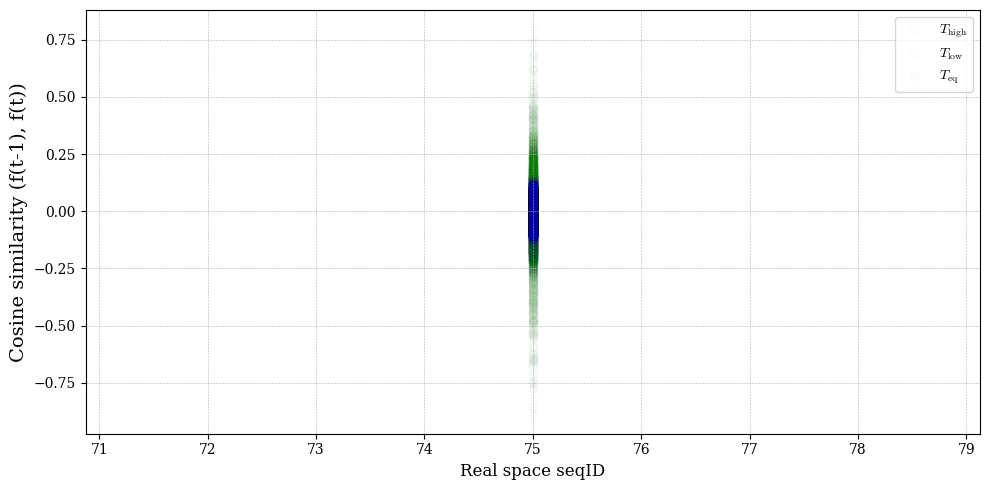

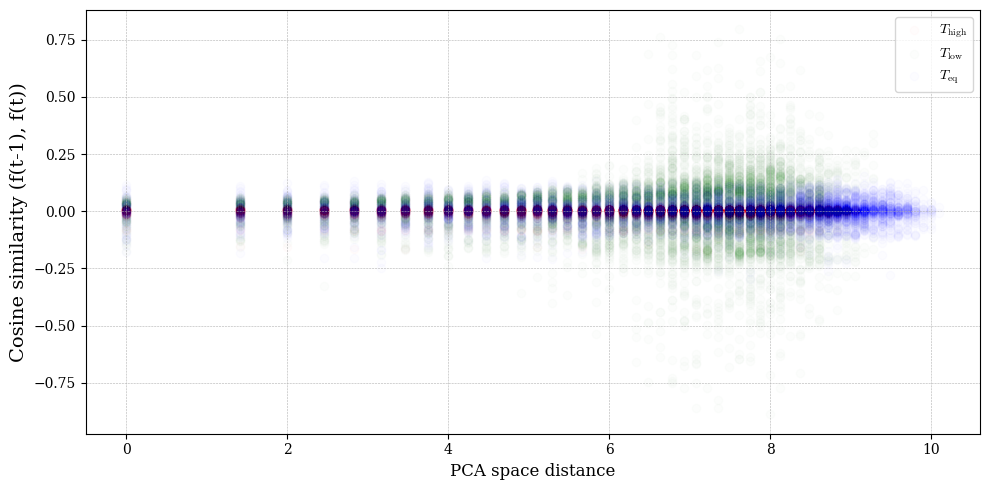

In [98]:
succ_cosf_Teq = torch.tensor([[cosine_sim(f_Teq[m, i, :], n_Teq[m, i+1, :]) for i in range(T-2)] for m in range(M)])
succ_cosf_Thigh = torch.tensor([[cosine_sim(f_Thigh[m, i, :], n_Thigh[m, i+1, :]) for i in range(T-2)] for m in range(M)])
succ_cosf_Tlow = torch.tensor([[cosine_sim(f_Tlow[m, i, :], n_Tlow[m, i+1, :]) for i in range(T-2)] for m in range(M)])

ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(succ_d_Teq.cpu(), succ_cosf_Thigh.cpu(), alpha = 0.01, color="red",   label="$T_{\\text{high}}$")
ax.scatter(succ_d_Tlow.cpu(), succ_cosf_Tlow.cpu(),  alpha = 0.01, color="green", label="$T_{\\text{low}}$")
ax.scatter(succ_d_Thigh.cpu(), succ_cosf_Teq.cpu(),   alpha = 0.01, color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("Real space seqID", fontsize=12)
ax.set_ylabel(r"Cosine similarity (f(t-1), f(t))", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/succ_cosf_seqID_{suffix}.png")
plt.show()


g, ax = plt.subplots(figsize=(10, 5))

ax.scatter(succ_dpca_Teq.cpu(), succ_cosf_Thigh.cpu(), alpha = 0.01, color="red",   label="$T_{\\text{high}}$")
ax.scatter(succ_dpca_Tlow.cpu(), succ_cosf_Tlow.cpu(),  alpha = 0.01, color="green", label="$T_{\\text{low}}$")
ax.scatter(succ_dpca_Thigh.cpu(), succ_cosf_Teq.cpu(),   alpha = 0.01, color="blue",  label="$T_{\\text{eq}}$")

ax.set_xlabel("PCA space distance", fontsize=12)
ax.set_ylabel(r"Cosine similarity (f(t-1), f(t))", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/succ_cosf_pca_{suffix}.png")
plt.show()

## Quiver plot in pca space

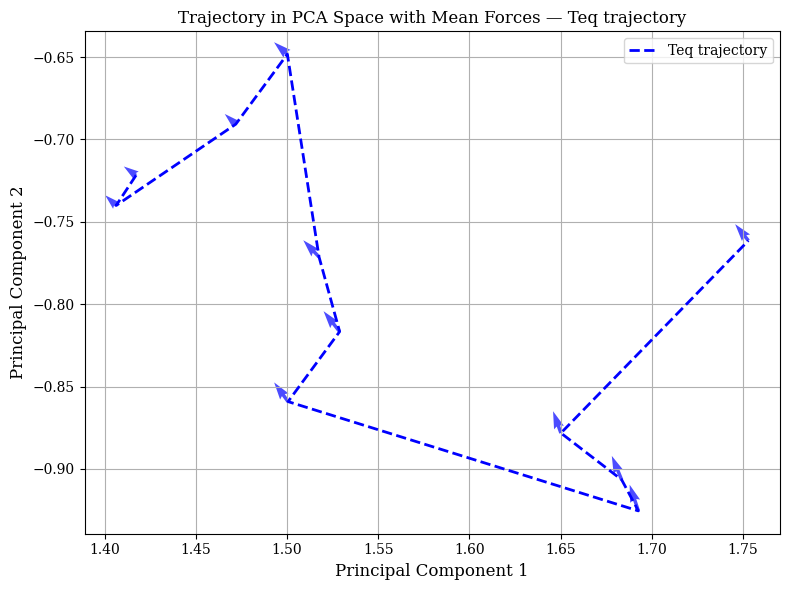

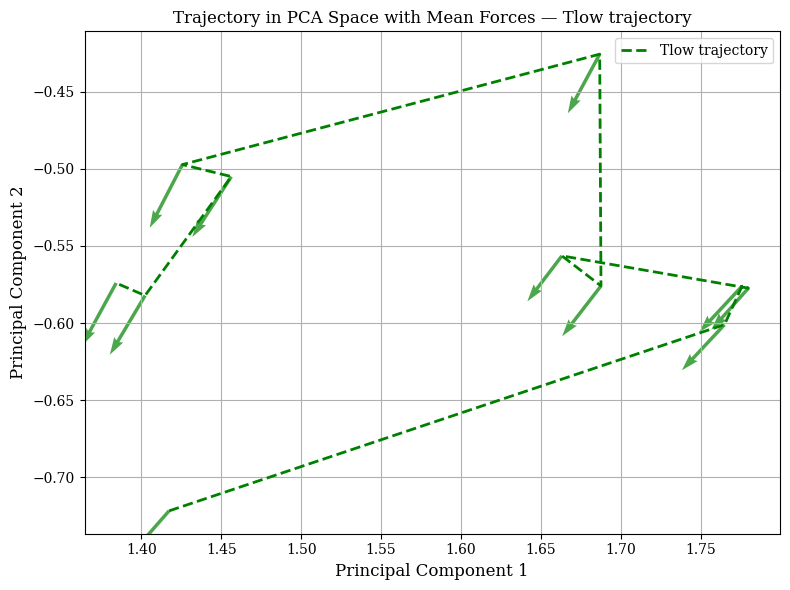

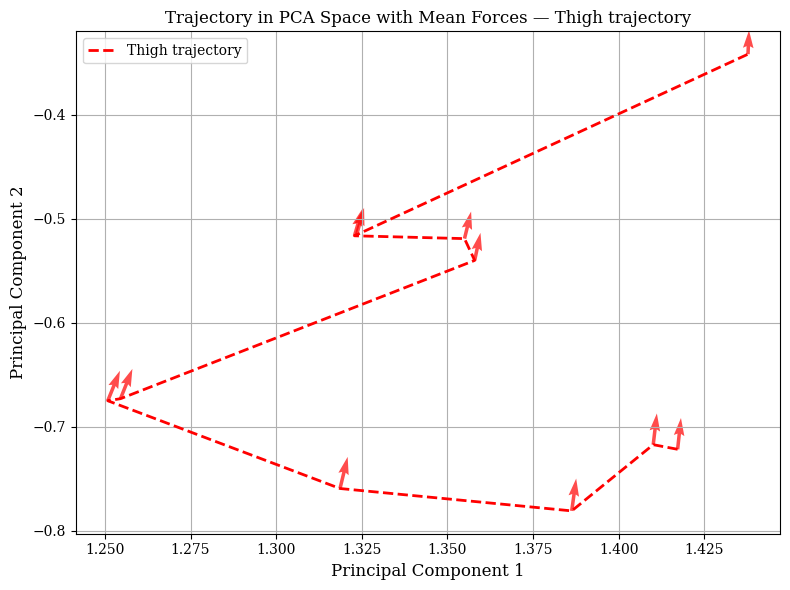

In [86]:
import matplotlib.pyplot as plt

def plot_trajectory_with_forces(traj_n, pcs, forces, color, label, filename):
    plt.figure(figsize=(8, 6))

    # Trajectory line
    plt.plot(
        pcs[traj_n, :, 0],
        pcs[traj_n, :, 1],
        color=color,
        linewidth=2,
        linestyle = "--",
        label=label
    )

    # Force arrows
    plt.quiver(
        pcs[traj_n, :, 0], pcs[traj_n, :, 1],
        forces[traj_n, :, 0], forces[traj_n, :, 1],
        angles='xy', scale_units='xy', scale=0.8,
        width=0.005, alpha=0.7, color=color
    )

    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.title(f'Trajectory in PCA Space with Mean Forces — {label}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save figure
    plt.savefig(filename, dpi=300)
    plt.show()


traj_n = 0
T_traj = 11

# ---- Teq (blue) ----
plot_trajectory_with_forces(traj_n,
    pcs=pcs_Teq[:,:T_traj,:].cpu(),
    forces=f_Teq[:,:T_traj,:].cpu(),
    color='blue',
    label='Teq trajectory',
    filename=f'../figures/trajectory_Teq_traj{traj_n}.png'
)

# ---- Tlow (green) ----
plot_trajectory_with_forces(traj_n,
    pcs=pcs_Tlow[:,:T_traj,:].cpu(),
    forces=f_Tlow[:,:T_traj,:].cpu(),
    color='green',
    label='Tlow trajectory',
    filename=f'../figures/trajectory_Tlow_traj{traj_n}.png'
)

# ---- Thigh (red) ----
plot_trajectory_with_forces(traj_n,
    pcs=pcs_Thigh[:,:T_traj,:].cpu(),
    forces=f_Thigh[:,:T_traj,:].cpu(),
    color='red',
    label='Thigh trajectory',
    filename=f'../figures/trajectory_Thigh_traj{traj_n}.png'
)



In [87]:
import matplotlib.pyplot as plt

def plot_trajectory_with_forces(traj_n, pcs, forces, color, label, filename):
    plt.figure(figsize=(8, 6))

    x = pcs[traj_n, :, 0]
    y = pcs[traj_n, :, 1]
    fx = forces[traj_n, :, 0]
    fy = forces[traj_n, :, 1]

    # ---- dotted line connecting points ----
    plt.plot(
        x, y,
        color=color,
        linestyle=':',
        linewidth=1.5,
        label=label
    )

    # ---- points ----
    plt.scatter(x, y, color=color, s=40)

    # ---- start marker ----
    plt.scatter(
        x[0], y[0],
        color=color,
        s=160,
        marker='D',
        edgecolor='black',
        linewidth=1.2,
        label='Start'
    )

    # ---- end marker ----
    plt.scatter(
        x[-1], y[-1],
        color=color,
        s=160,
        marker='X',
        edgecolor='black',
        linewidth=1.2,
        label='End'
    )

    # ---- force arrows ----
    plt.quiver(
        x, y, fx, fy,
        angles='xy',
        scale_units='xy',
        scale=0.2,
        width=0.005,
        alpha=0.7,
        color=color
    )

    # ---- labels ----
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.title(f'Trajectory in PCA Space with Mean Forces — {label}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.savefig(filename, dpi=300)
    plt.show()


# -------------------------
# Run all three trajectories
# -------------------------

traj_n = 10
T_traj = 50

# ---- Teq (blue) ----
plot_trajectory_with_forces(
    traj_n,
    pcs=pcs_Teq[:, :T_traj, :].cpu(),
    forces=f_Teq[:, :T_traj, :].cpu(),
    color='blue',
    label='Teq trajectory',
    filename=f'../figures/trajectory_Teq_traj{traj_n}.png'
)

# ---- Tlow (green) ----
plot_trajectory_with_forces(
    traj_n,
    pcs=pcs_Tlow[:, :T_traj, :].cpu(),
    forces=f_Tlow[:, :T_traj, :].cpu(),
    color='green',
    label='Tlow trajectory',
    filename=f'../figures/trajectory_Tlow_traj{traj_n}.png'
)

# ---- Thigh (red) ----
plot_trajectory_with_forces(
    traj_n,
    pcs=pcs_Thigh[:, :T_traj, :].cpu(),
    forces=f_Thigh[:, :T_traj, :].cpu(),
    color='red',
    label='Thigh trajectory',
    filename=f'../figures/trajectory_Thigh_traj{traj_n}.png'
)


IndexError: index 10 is out of bounds for dimension 0 with size 10

<Figure size 800x600 with 0 Axes>

## Direct paths

In [202]:
N_paths = 50
N_endpoints = 100
start_seq = msa_enc[0]
d_direct = 76 - get_seqid(msa_oh[0], msa_oh[1:N_endpoints])
mean_work = []; std_work = []
for n in range(1,N_endpoints):
    end_seq = msa_enc[n]
    #get where sequences differ
    diff_positions = (start_seq != end_seq).nonzero(as_tuple=True)[0]
    #shuffle diff positions
    mut_paths = [diff_positions[torch.randperm(len(diff_positions))] for i in range(N_paths)]
    #for each path  draw a trajectory going through the mutations in that order
    mut_trajs = []
    for path in mut_paths:
        traj = start_seq.clone()
        trajs = [traj.clone()]
        for pos in path:
            traj[pos] = end_seq[pos]
            trajs.append(traj.clone())
        mut_trajs.append(torch.stack(trajs))  

    #one hot encode mut_trajs and stack them to be M,T,L,q
    # M = number of mutation paths
    # T = number of steps in each path
    # L = sequence length
    #   q = number of amino acids
    mut_trajs_oh = torch.stack([one_hot(mut_traj, q).to(device) for mut_traj in mut_trajs]).to(device)
    gibbs_traj = torch.stack([compute_gibbs_probabilities(mut_trajs_oh[i], params, beta=1.0, remove_self_loop=True) 
                            for i in range(len(mut_trajs_oh))]).to(device)
    f_traj, n_traj, displ_traj, pcs_traj = calculate_forces_and_noises(mut_trajs_oh, gibbs_traj, pca, device)
    final_work = (f_traj*displ_traj).sum(dim=2).cumsum(dim=1)[:,-1]
    mean_work.append(final_work.mean().item())
    std_work.append(final_work.std().item())
    print(n)




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


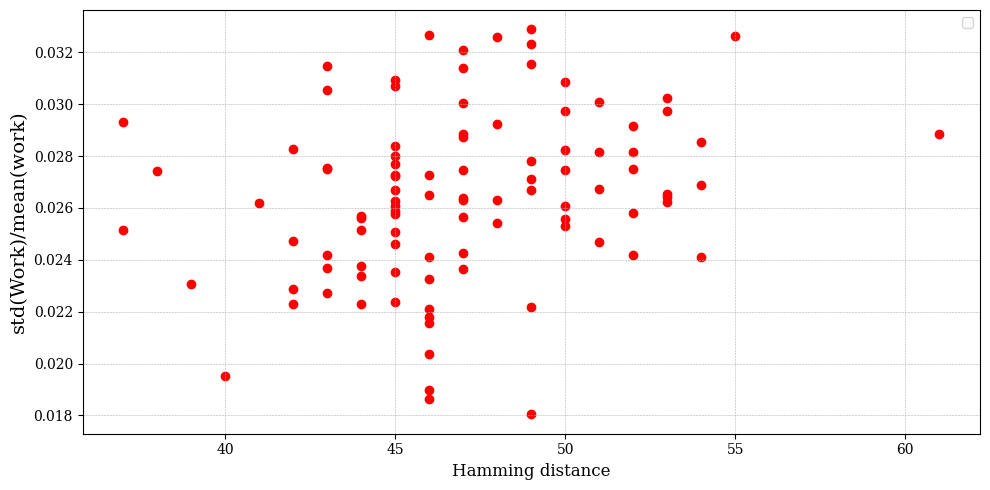

In [204]:
ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(d_direct.cpu(), (torch.tensor(std_work)/ torch.tensor(mean_work)).cpu(), color="red")

ax.set_xlabel("Hamming distance", fontsize=12)
ax.set_ylabel(r"std(Work)/mean(work)", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/conservativity_work_direct_paths.png")
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


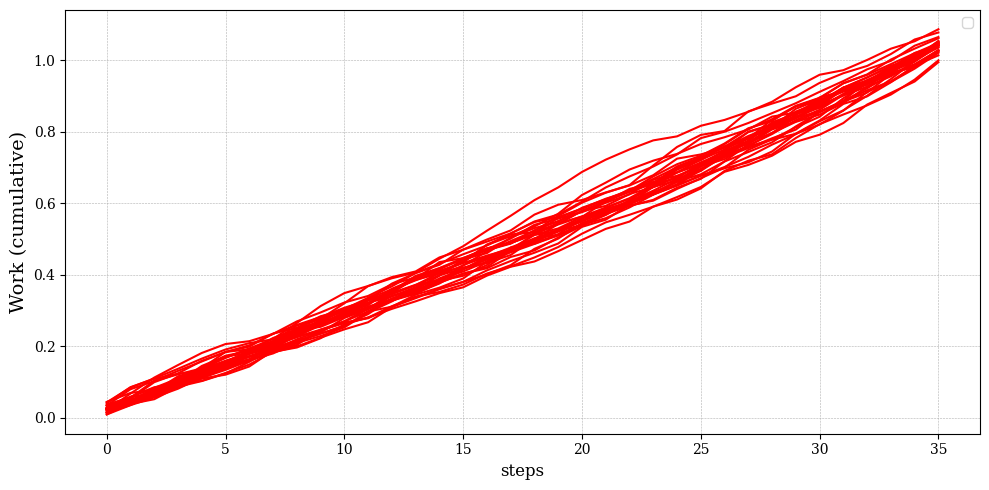

In [177]:
ig, ax = plt.subplots(figsize=(10, 5))

ax.plot((f_traj*displ_traj).sum(dim=2).cumsum(dim=1).cpu().T, color="red")

ax.set_xlabel("steps", fontsize=12)
ax.set_ylabel(r"Work (cumulative)", fontsize=14)

ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()

plt.tight_layout()
plt.savefig(f"../figures/work_direct_paths.png")
plt.show()

In [180]:
final_work = (f_traj*displ_traj).sum(dim=2).cumsum(dim=1)[:,-1]
print("Average final work along direct paths:", final_work.mean().item())
print("Std of final work along direct paths:", final_work.std().item())

Average final work along direct paths: 1.0411523580551147
Std of final work along direct paths: 0.019733767956495285


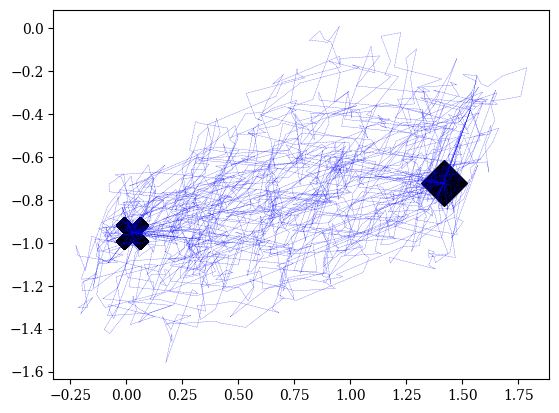

In [129]:
for traj_n in range(len(mut_trajs_oh)):
    
    plt.plot(
            pcs_traj[traj_n, :, 0].cpu(),
            pcs_traj[traj_n, :, 1].cpu(),
            color=color,
            linewidth=0.2,
            linestyle = "--",
            label=label
        )
    plt.scatter(
        pcs_traj[traj_n, 0, 0].cpu(),
        pcs_traj[traj_n, 0, 1].cpu(),
        color="black",
        s=500,
        marker='D',
        edgecolor='black',
        linewidth=1.2,
        label='Start'
    )
    plt.scatter(
        pcs_traj[traj_n, -1, 0].cpu(),
        pcs_traj[traj_n, -1, 1].cpu(),
        color="black",
        s=500,
        marker='X',
        edgecolor='black',
        linewidth=1.2,
        label='End'
    )
plt.savefig("../figures/trajectory_direct_paths.png")
plt.show()

## Static analysis on natural sequences

In [368]:
def calculate_forces_pcs(
    seqs: torch.Tensor,      # (M_big, L, q)
    gibbs: torch.Tensor,     # (L, M_big, q)
    pca,                     # Trained PCA object
    device: torch.device,
    M_batch: int = 100
):
    import gc

    all_forces = []
    all_pcs = []

    M_big, L, q = seqs.shape

    # Cap batch size automatically
    M_batch = min(M_batch, M_big)

    # Pre-permute gibbs once for efficiency: (L, M_big, q) -> (M_big, L, q)
    gibbs = gibbs.permute(1, 0, 2)

    # Loop in adaptive chunks
    for start in range(0, M_big, M_batch):
        end = min(start + M_batch, M_big)

        seqs_batch = seqs[start:end]           # (m, L, q)
        gibbs_batch = gibbs[start:end]         # (m, L, q)
        m = end - start

        # PCA projections for DMS
        dms_pc = torch.stack(
            generate_dms_and_project_batch_timed(seqs_batch, pca)
        ).to(device)                           # (m, Lq+1, lq)

        # Displacements
        dms_displ = dms_pc[:, 1:, :] - dms_pc[:, 0, :].unsqueeze(1)

        # Expand gibbs: (m, L, q) -> (m, L*q, 1)
        W = gibbs_batch.reshape(m, L * q).unsqueeze(-1)

        # Weighted average force
        force = (W * dms_displ).sum(dim=1) / W.sum(dim=1)

        # Collect
        all_forces.append(force)
        all_pcs.append(dms_pc[:, 0, :])

        # Cleanup
        del dms_displ, W, force, dms_pc, seqs_batch, gibbs_batch
        gc.collect()
        torch.cuda.empty_cache()

    final_forces = torch.cat(all_forces, dim=0)
    final_pcs = torch.cat(all_pcs, dim=0)

    return final_forces, final_pcs




In [375]:
M_big = 1000
beta_eq = 1.0
molec_time = True
# M, L, T, q
gibbs_big = compute_gibbs_probabilities(nat_msa_oh[:M_big], params, beta=beta_eq, remove_self_loop=True)
gibbs_big.shape

suffix = "mol_time" if molec_time else "real_time"
suffix


'mol_time'

In [376]:
f, pcs = calculate_forces_pcs(msa_oh[:M_big], gibbs_big[:M_big], pca, device = device)


In [377]:
dpca = []
df = []
dreal = []
cosf = []
for i in range(M_big):
    dpca.append( torch.sqrt((((pcs - pcs[i].unsqueeze(0))**2).sum(dim=1))))
    df.append(torch.sqrt((((f - f[i].unsqueeze(0))**2).sum(dim=1))))
    dreal.append( get_seqid(msa_oh[i], msa_oh[:M_big]))
    cosf.append(torch.tensor([cosine_sim(f[i, :], f[j, :])for j in range(M_big)]))

dpca = torch.stack(dpca)
df = torch.stack(df)
dreal = torch.stack(dreal)
cosf = torch.stack(cosf)

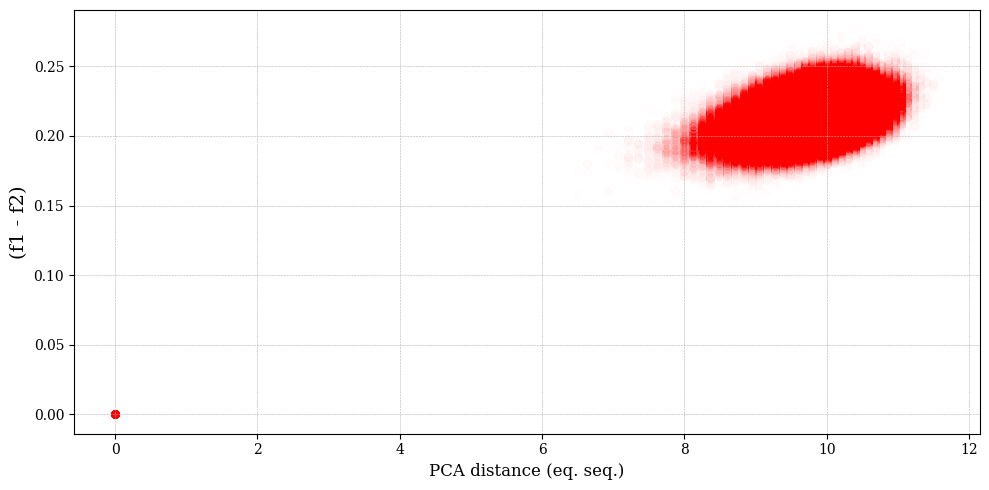

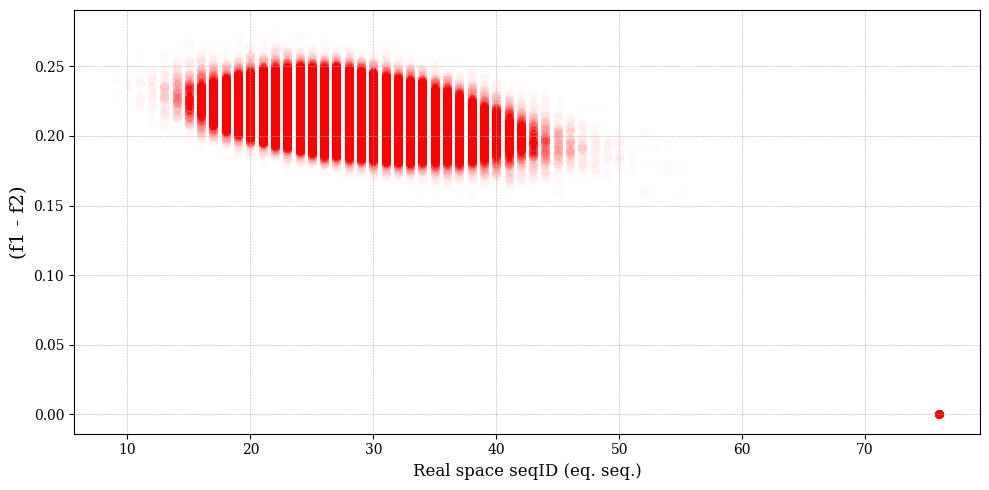

In [378]:
ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(dpca.flatten().cpu(), df.flatten().cpu(), alpha = 0.005, color="red")

ax.set_xlabel("PCA distance (eq. seq.)", fontsize=12)
ax.set_ylabel(r"(f1 - f2)", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.4)

plt.tight_layout()
plt.savefig(f"../figures/static_df_dpca_{suffix}.png")
plt.show()

ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(dreal.flatten().cpu(), df.flatten().cpu(), alpha = 0.005, color="red")

ax.set_xlabel("Real space seqID (eq. seq.)", fontsize=12)
ax.set_ylabel(r"(f1 - f2)", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.4)

plt.tight_layout()
plt.savefig(f"../figures/static_df_dreal_{suffix}.png")
plt.show()

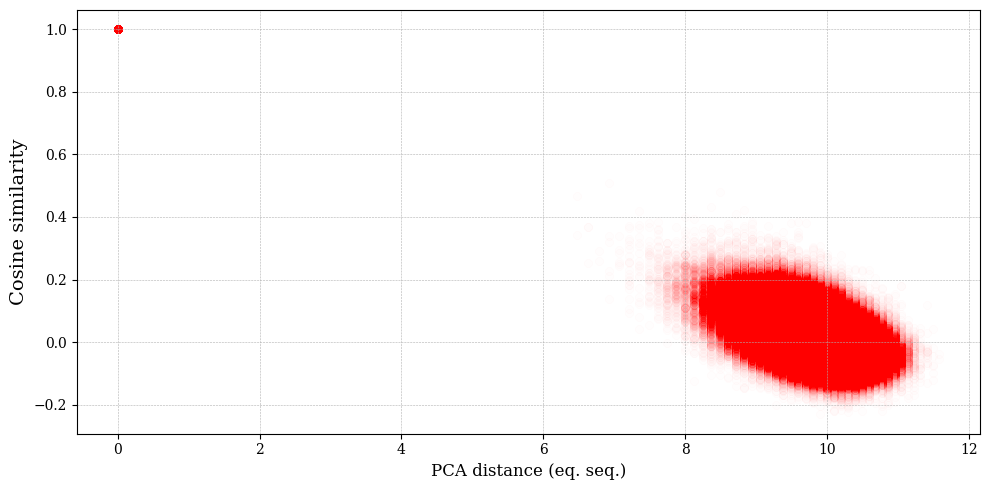

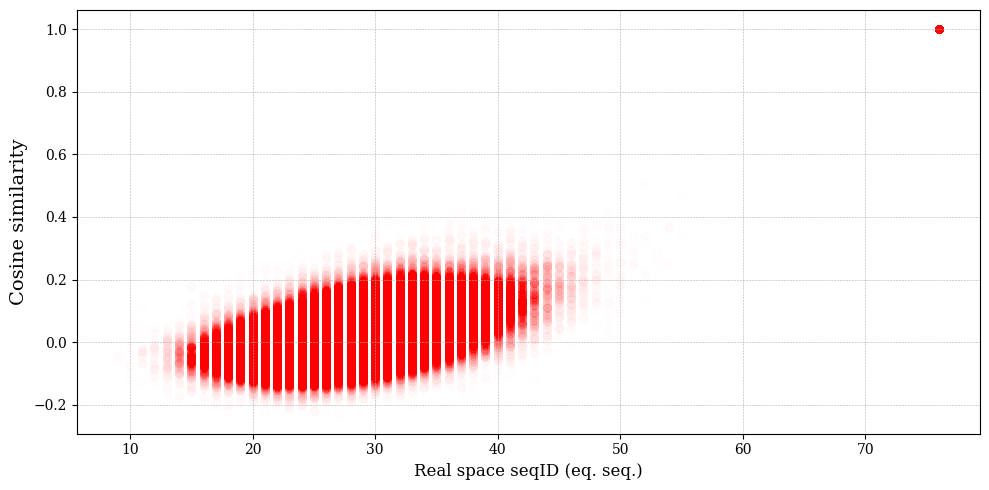

In [379]:
ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(dpca.flatten().cpu(), cosf.flatten().cpu(), alpha = 0.005, color="red")

ax.set_xlabel("PCA distance (eq. seq.)", fontsize=12)
ax.set_ylabel(r"Cosine similarity", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.4)

plt.tight_layout()
plt.savefig(f"../figures/static_cosf_dpca_{suffix}.png")
plt.show()

ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(dreal.flatten().cpu(), cosf.flatten().cpu(), alpha = 0.005, color="red")

ax.set_xlabel("Real space seqID (eq. seq.)", fontsize=12)
ax.set_ylabel(r"Cosine similarity", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.4)

plt.tight_layout()
plt.savefig(f"../figures/static_cosf_dreal_{suffix}.png")
plt.show()

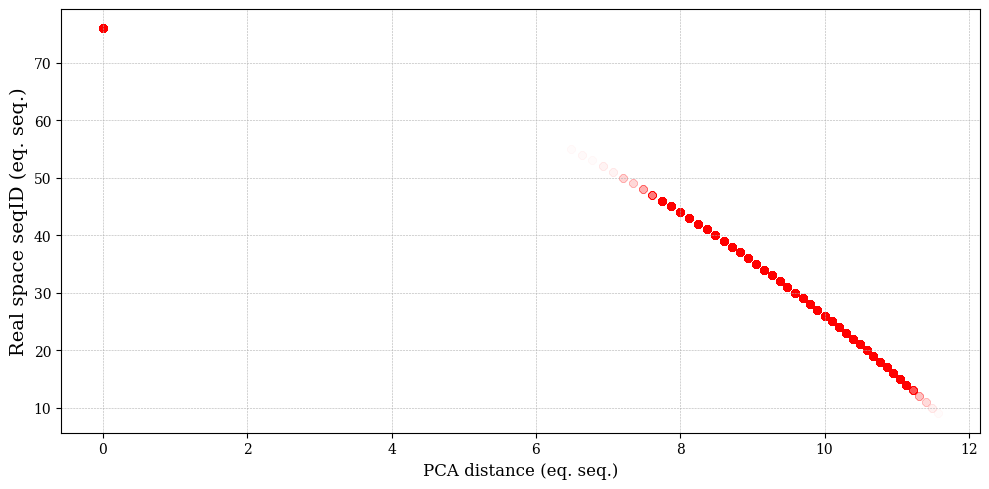

In [380]:
ig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(dpca.flatten().cpu(), dreal.flatten().cpu(), alpha = 0.005, color="red")

ax.set_xlabel("PCA distance (eq. seq.)", fontsize=12)
ax.set_ylabel(r"Real space seqID (eq. seq.)", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.4)

plt.tight_layout()
plt.savefig(f"../figures/static_dreal_dpca_{suffix}.png")
plt.show()

## Covariance matrix

In [ ]:
# --- FUNZIONE PRINCIPALE: Calcola Forza e Covarianza ---
def calculate_weighted_force_and_cov(
    seqs: torch.Tensor,    # (L, q) - La sequenza one-hot
    gibbs: torch.Tensor,   # (L, q) - I pesi Gibbs
    pca_mock,              # Oggetto PCA (mock o reale)
    device: torch.device,
    n_pc_subset: int = None
):
    """
    Calcola la Forza (media pesata degli spostamenti Delta-X) e la matrice di 
    Covarianza pesata degli spostamenti Delta-X nello spazio PCA.

    Args:
        seqs: (L, q) sequenza one-hot (senza dimensione batch M=1).
        gibbs: (L, q) pesi Gibbs (senza dimensione batch M=1).
        pca_mock: oggetto PCA addestrato.
        device: dispositivo torch.
        n_pc_subset: numero di componenti PCA da mantenere.

    Returns:
        force: Vettore della forza (media pesata deltax), dimensione (n_pc_subset,).
        cov: Matrice di covarianza pesata, dimensione (n_pc_subset, n_pc_subset).
        pc_t0: Proiezione PCA a t=0 (n_pcs,).
    """
    
    L, q = seqs.shape
    
    # 1. Preparazione degli Input e Proiezioni PCA
    
    # Reintroduzione dimensione batch (M=1) per la funzione di proiezione
    seqs_batch = seqs.unsqueeze(0).to(device) # (1, L, q)
    gibbs_flat = gibbs.to(device)             # (L, q)

    # Proiezioni PCA: (Lq+1, n_pcs)
    # L'output è [tensor(1, Lq+1, n_pcs)]. Squeeze(0) rimuove M=1.
    dms_pc = torch.stack(generate_dms_and_project_batch_timed(seqs_batch, pca_mock)).squeeze(0).to(device) 

    if n_pc_subset is not None:
        dms_pc = dms_pc[:, :n_pc_subset]
        
    n_pcs = dms_pc.shape[1] # n_pc_subset (corrisponde a n nella notazione)

    # 2. Spostamenti (Delta-X)
    
    # D_displ: Spostamenti Delta-X, (Lq, n_pcs)
    # D_pc[0, :] è la proiezione iniziale, espansa a (1, n_pcs) per la sottrazione
    D = dms_pc[1:, :] - dms_pc[0, :].unsqueeze(0) 
    
    # W_pos: Pesi per posizione (Lq,)
    W_pos = gibbs_flat.flatten()     
    # Somma totale dei pesi (W_sum)
    W_sum = W_pos.sum()
    
    # Prevenzione divisione per zero
    if W_sum.item() == 0:
        return torch.zeros(n_pcs), torch.zeros((n_pcs, n_pcs)), dms_pc[0, :].cpu()

    # 4. Calcolo della Forza (Media Pesata Delta-X)
    
    # F = (D^T * W_pos) / W_sum. Moltiplicazione elemento per elemento (broadcasting)
    force = (D.T * W_pos).sum(dim=1) / W_sum  # (n_pcs,)

    # 5. Calcolo della Covarianza Pesata (n_pcs x n_pcs)
    
    # Dati centrati (Delta-X centrato): (L, n_pcs)
    D_centered = D - force.unsqueeze(0)                            

    # Covarianza: C = D_centered^T @ diag(W_pos) @ D_centered / W_sum
    # (D_centered.T * W_pos) implementa D_centered^T @ diag(W_pos)
    cov = (D_centered.T * W_pos) @ D_centered / W_sum               # (n_pcs, n_pcs)

    # Proiezione t=0
    pc_t0 = dms_pc[0, :].cpu()

    # 6. Pulizia
    del D, D_centered, dms_pc, seqs_batch, gibbs_flat
    gc.collect()
    torch.cuda.empty_cache()

    return force, cov, pc_t0


def off_diagonal_frobenius(A):
    """
    Frobenius norm of off-diagonal entries using PyTorch.
    Works on CPU or CUDA tensors.
    """
    diag = torch.diag(torch.diag(A))
    off_diag = A - diag
    return torch.norm(off_diag, p='fro')


def off_diagonal_ratio(A):
    """
    Normalized off-diagonal Frobenius norm using PyTorch.
    r(A) = ||A - diag(A)||_F^2 / ||A||_F^2
    """
    diag = torch.diag(torch.diag(A))
    off_diag = A - diag
    num = torch.sum(off_diag**2)
    den = torch.sum(A**2)
    return num / den

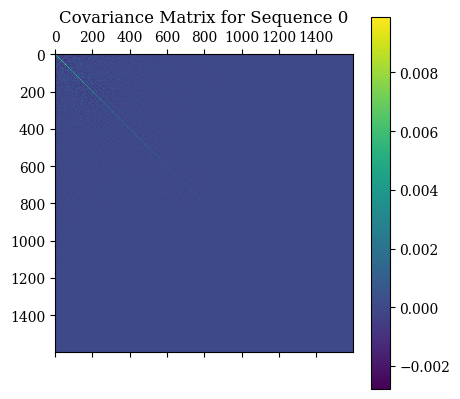

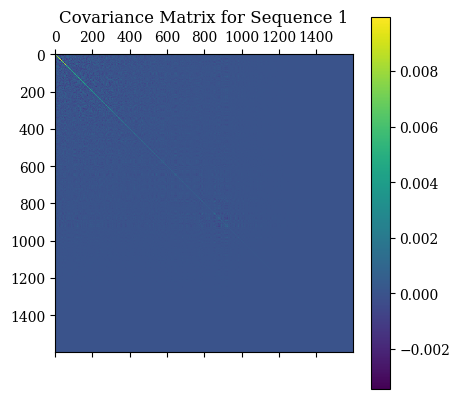

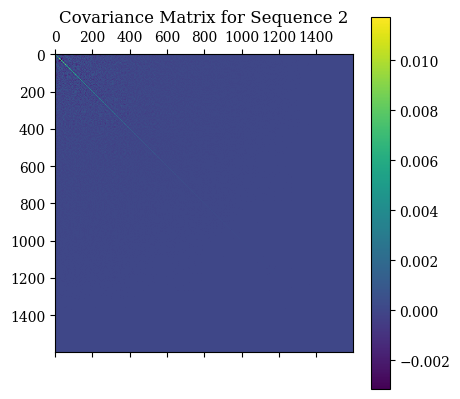

In [262]:
n_pc_subset = 1596
for m in range(3):

    f, cov, pc_seq = calculate_weighted_force_and_cov(
        msa_oh[m],    # (1, L, q) - La sequenza singola
        gibbs_big[:,1,:],   # (L, 1, q) - I pesi Gibbs per la sequenza
        pca,
        device,
        n_pc_subset = n_pc_subset
    )
    
    plt.matshow(cov.cpu().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title(f'Covariance Matrix for Sequence {m}')
    plt.savefig(f"../figures/cov_matrix_seq{m}_pc{n_pc_subset}.png")
    plt.show()


In [303]:
n_pc_subset = 1596
ndis = []
for m in range(100):

    f, cov, pc_seq = calculate_weighted_force_and_cov(
        msa_oh[m],    # (1, L, q) - La sequenza singola
        gibbs_big[:,m,:],   # (L, 1, q) - I pesi Gibbs per la sequenza
        pca,
        device,
        n_pc_subset = n_pc_subset
    )
    ndis.append(off_diagonal_ratio(cov).cpu().item())

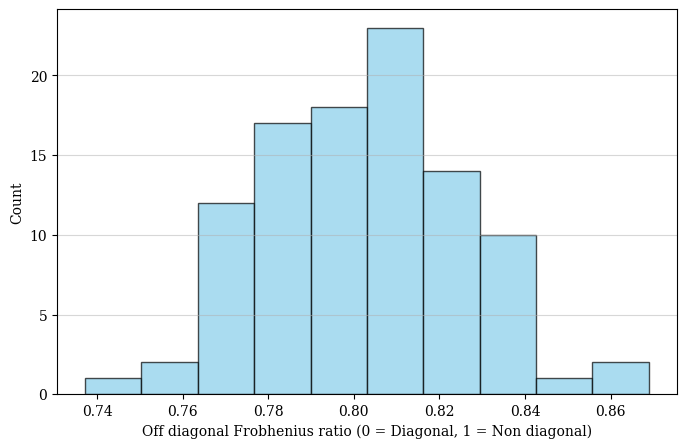

In [305]:
plt.figure(figsize=(8, 5))
plt.hist(ndis, edgecolor='black', alpha=0.7, color='skyblue')# density=True)
plt.xlabel('Off diagonal Frobhenius ratio (0 = Diagonal, 1 = Non diagonal)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.5)
plt.savefig(f"../figures/ndi_histogram_pc{n_pc_subset}.png")
plt.show()

In [302]:
gibbs_Teq.shape

torch.Size([10, 76, 77, 21])

In [308]:
T = trajs_Teq.shape[1]
n_pc_subset = 1596
covs_Teq = []
for m in range(T):

    f, cov, pc_seq = calculate_weighted_force_and_cov(
        trajs_Teq[0,m,:,:],    # (1, L, q) - La sequenza singola
        gibbs_Teq[0,:,m,:],   # (L, 1, q) - I pesi Gibbs per la sequenza
        pca,
        device,
        n_pc_subset = n_pc_subset
    )
    covs_Teq.append(cov)


covs_Thigh = []
for m in range(T):

    f, cov, pc_seq = calculate_weighted_force_and_cov(
        trajs_Thigh[0,m,:,:],    # (1, L, q) - La sequenza singola
        gibbs_Thigh[0,:,m,:],   # (L, 1, q) - I pesi Gibbs per la sequenza
        pca,
        device,
        n_pc_subset = n_pc_subset
    )
    covs_Thigh.append(cov)


covs_Tlow = []
for m in range(T):

    f, cov, pc_seq = calculate_weighted_force_and_cov(
        trajs_Tlow[0,m,:,:],    # (1, L, q) - La sequenza singola
        gibbs_Tlow[0,:,m,:],   # (L, 1, q) - I pesi Gibbs per la sequenza
        pca,
        device,
        n_pc_subset = n_pc_subset
    )
    covs_Tlow.append(cov)




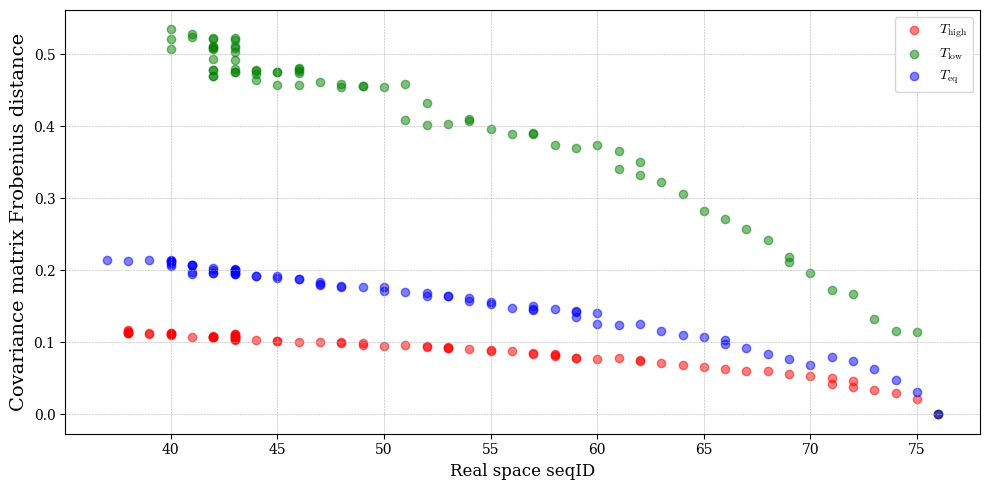

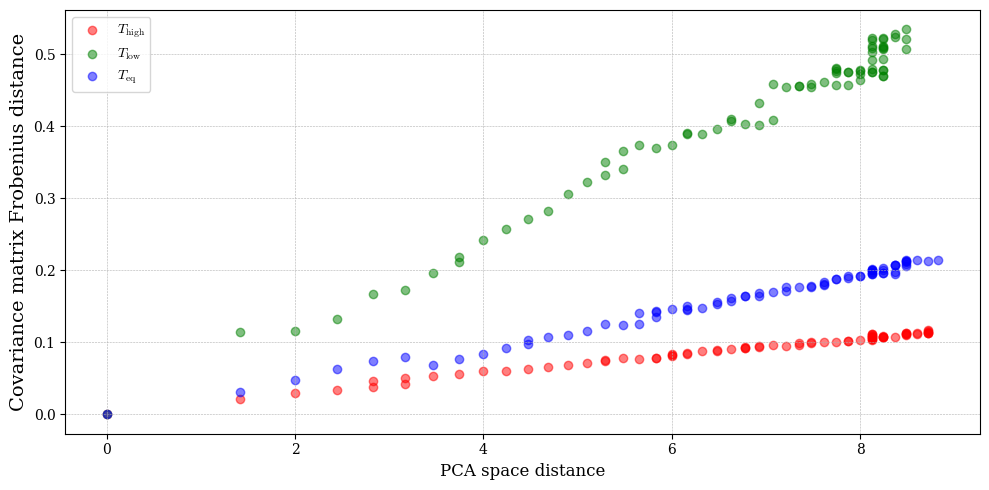

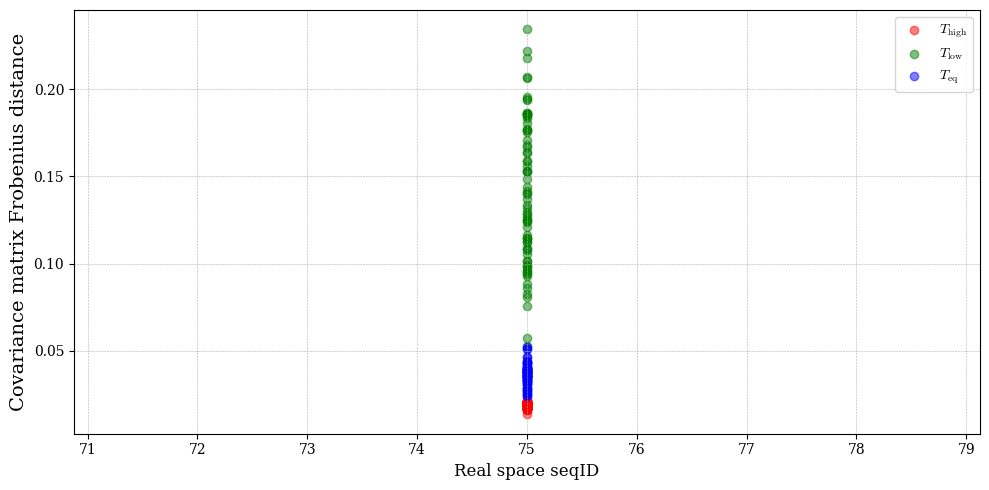

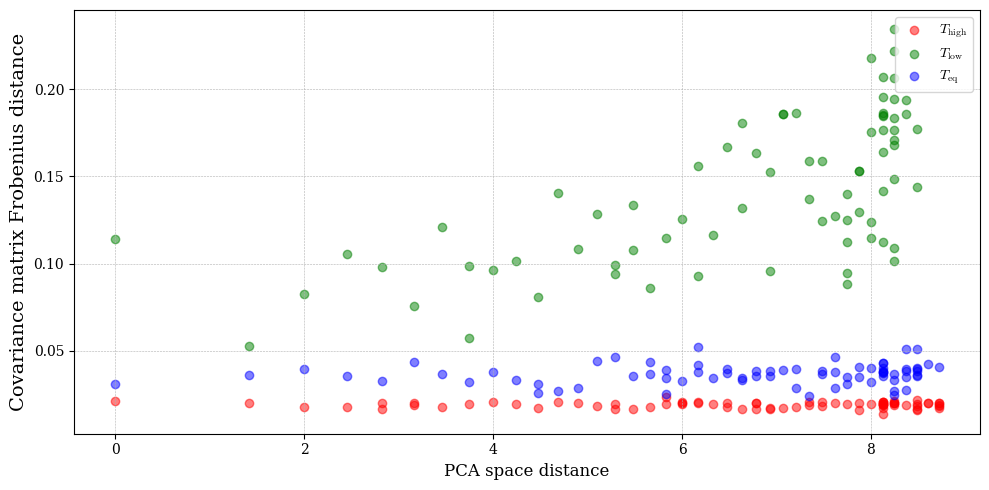

In [328]:
dcov_Teq = torch.stack([torch.norm(covs_Teq[0] - covs_Teq[i], p='fro') for i in range(T-1)])
dcov_Thigh = torch.stack([torch.norm(covs_Thigh[0] - covs_Thigh[i], p='fro') for i in range(T-1)])
dcov_Tlow = torch.stack([torch.norm(covs_Tlow[0] - covs_Tlow[i], p='fro') for i in range(T-1)])

ig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(d_Teq[0].cpu(), dcov_Thigh.cpu(), alpha = 0.5, color="red",   label="$T_{\\text{high}}$")
ax.scatter(d_Tlow[0].cpu(), dcov_Tlow.cpu(),  alpha = 0.5, color="green", label="$T_{\\text{low}}$")
ax.scatter(d_Thigh[0].cpu(), dcov_Teq.cpu(),   alpha = 0.5, color="blue",  label="$T_{\\text{eq}}$")
ax.set_xlabel("Real space seqID", fontsize=12)
ax.set_ylabel(r"Covariance matrix Frobenius distance", fontsize=14) 
ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()
plt.tight_layout()
plt.savefig(f"../figures/dcov_seqID_{suffix}.png")
plt.show()

ig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(dpca_Teq[0].cpu(), dcov_Thigh.cpu(), alpha = 0.5, color="red",   label="$T_{\\text{high}}$")
ax.scatter(dpca_Tlow[0].cpu(), dcov_Tlow.cpu(),  alpha = 0.5, color="green", label="$T_{\\text{low}}$")
ax.scatter(dpca_Thigh[0].cpu(), dcov_Teq.cpu(),   alpha = 0.5, color="blue",  label="$T_{\\text{eq}}$")
ax.set_xlabel("PCA space distance", fontsize=12)
ax.set_ylabel(r"Covariance matrix Frobenius distance", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend() 
plt.tight_layout()
plt.savefig(f"../figures/dcov_pca_{suffix}.png")
plt.show()

succ_dcov_Teq = torch.stack([torch.norm(covs_Teq[i] - covs_Teq[i+1], p='fro') for i in range(T-2)])
succ_dcov_Thigh = torch.stack([torch.norm(covs_Thigh[i] - covs_Thigh[i+1], p='fro') for i in range(T-2)])
succ_dcov_Tlow = torch.stack([torch.norm(covs_Tlow[i] - covs_Tlow[i+1], p='fro') for i in range(T-2)])  

ig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(succ_d_Teq[0].cpu(), succ_dcov_Thigh.cpu(), alpha = 0.5, color="red",   label="$T_{\\text{high}}$")
ax.scatter(succ_d_Tlow[0].cpu(), succ_dcov_Tlow.cpu(), alpha = 0.5, color="green", label="$T_{\\text{low}}$")
ax.scatter(succ_d_Thigh[0].cpu(), succ_dcov_Teq.cpu(),  alpha = 0.5,  color="blue",  label="$T_{\\text{eq}}$")
ax.set_xlabel("Real space seqID", fontsize=12)
ax.set_ylabel(r"Covariance matrix Frobenius distance", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()     
plt.tight_layout()
plt.savefig(f"../figures/succ_dcov_seqID_{suffix}.png")
plt.show()


ig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(succ_dpca_Teq[0].cpu(), succ_dcov_Thigh.cpu(), alpha = 0.5, color="red",   label="$T_{\\text{high}}$")
ax.scatter(succ_dpca_Tlow[0].cpu(), succ_dcov_Tlow.cpu(),  alpha = 0.5, color="green", label="$T_{\\text{low}}$") 
ax.scatter(succ_dpca_Thigh[0].cpu(), succ_dcov_Teq.cpu(),   alpha = 0.5, color="blue",  label="$T_{\\text{eq}}$")
ax.set_xlabel("PCA space distance", fontsize=12)
ax.set_ylabel(r"Covariance matrix Frobenius distance", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()
plt.tight_layout()
plt.savefig(f"../figures/succ_dcov_pca_{suffix}.png")
plt.show()


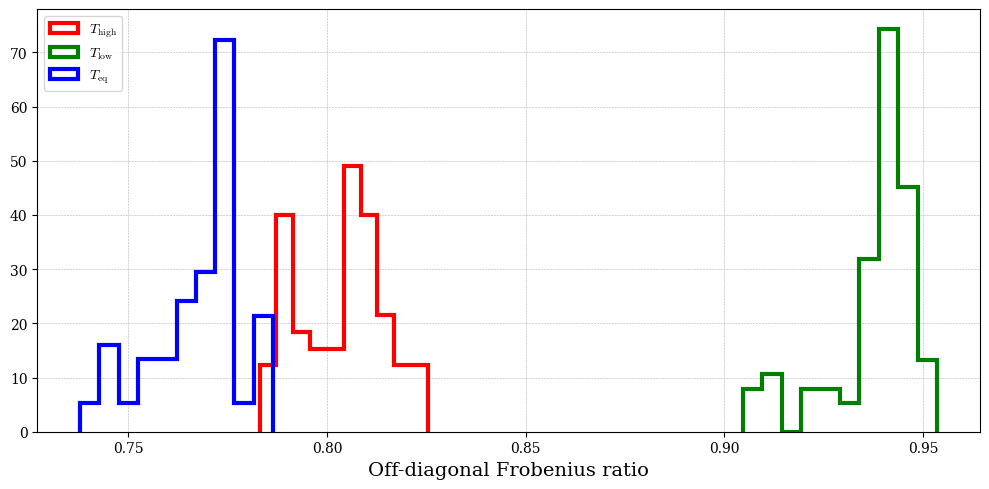

In [331]:
offdiag_Teq = torch.stack([off_diagonal_ratio(covs_Teq[i]) for i in range(T)])
offdiag_Tlow = torch.stack([off_diagonal_ratio(covs_Tlow[i]) for i in range(T)])
offdiag_Thigh = torch.stack([off_diagonal_ratio(covs_Thigh[i]) for i in range(T)])  

ig, ax = plt.subplots(figsize=(10, 5))
ax.hist(offdiag_Teq.cpu(), color="red", histtype = "step", density = True, linewidth = 3.0,  label="$T_{\\text{high}}$")
ax.hist(offdiag_Tlow.cpu(), color="green", histtype = "step", density = True, linewidth = 3.0, label="$T_{\\text{low}}$")
ax.hist(offdiag_Thigh.cpu(), color="blue", histtype = "step", density = True, linewidth = 3.0, label="$T_{\\text{eq}}$")
ax.set_xlabel(r"Off-diagonal Frobenius ratio", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.4)
ax.legend()
plt.tight_layout()
plt.savefig(f"../figures/offdiag_ratio_trajs{suffix}.png")
plt.show()  

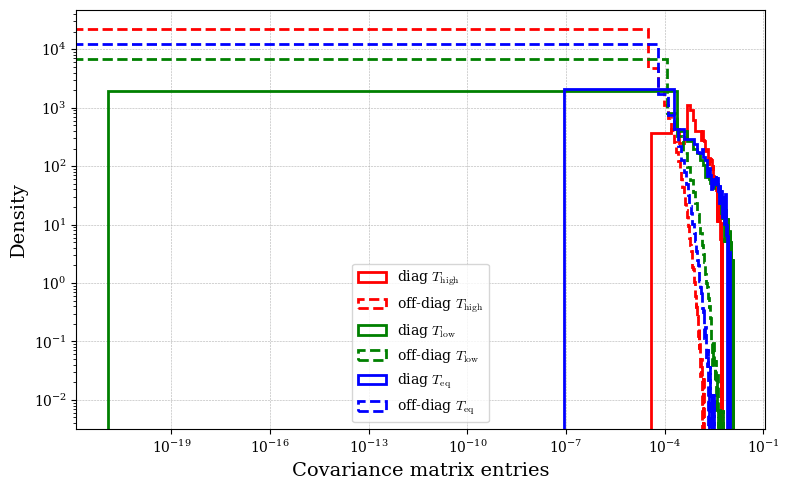

In [408]:
import torch
import matplotlib.pyplot as plt

def diag_part(M):
    return torch.diag(M)

def offdiag_part(M):
    return M - torch.diag(diag_part(M))

# Extract values
diag_high     = covs_Thigh[0].diag().cpu().numpy()
offdiag_high  = offdiag_part(covs_Thigh[0]).flatten().cpu().numpy()

diag_low      = covs_Tlow[0].diag().cpu().numpy()
offdiag_low   = offdiag_part(covs_Tlow[0]).flatten().cpu().numpy()

diag_eq       = covs_Teq[0].diag().cpu().numpy()
offdiag_eq    = offdiag_part(covs_Teq[0]).flatten().cpu().numpy()

plt.figure(figsize=(8,5))

# Thigh
plt.hist(diag_high,    bins=50, linewidth=2, color="red",   histtype="step", linestyle='-',  density=True, label=r"diag $T_{\text{high}}$")
plt.hist(abs(offdiag_high), bins=50, linewidth=2, color="red",   histtype="step", linestyle='--', density=True, label=r"off-diag $T_{\text{high}}$")

# Tlow
plt.hist(diag_low,     bins=50, linewidth=2, color="green", histtype="step", linestyle='-',  density=True, label=r"diag $T_{\text{low}}$")
plt.hist(abs(offdiag_low),  bins=50, linewidth=2, color="green", histtype="step", linestyle='--', density=True, label=r"off-diag $T_{\text{low}}$")

# Teq
plt.hist(diag_eq,      bins=50, linewidth=2, color="blue",  histtype="step", linestyle='-',  density=True, label=r"diag $T_{\text{eq}}$")
plt.hist(abs(offdiag_eq),   bins=50, linewidth=2, color="blue",  histtype="step", linestyle='--', density=True, label=r"off-diag $T_{\text{eq}}$")

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"Density", fontsize=14)
plt.xlabel(r"Covariance matrix entries", fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.4)
plt.legend()
plt.tight_layout()
plt.savefig(f"../figures/cov_matrix_entries_traj{suffix}.png")
plt.show()


In [411]:
W = pca.components_

# 2. Calculate W * W^T
# This confirms the orthonormality of the rows (the principal components)
W_dot_WT = W @ W.T

# 3. Check for numerical closeness to the Identity Matrix
identity_matrix = np.eye(W.shape[0])
is_orthogonal = np.allclose(W_dot_WT, identity_matrix)

print(f"Is W @ W.T numerically close to the Identity Matrix? {is_orthogonal}")

Is W @ W.T numerically close to the Identity Matrix? False


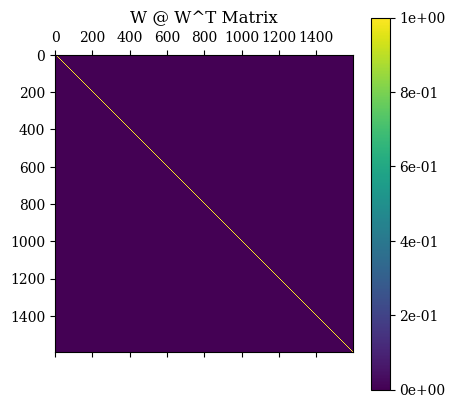

In [418]:
plt.matshow(W_dot_WT)
#colorbar in log scale
plt.colorbar(format='%.0e')
plt.title("W @ W^T Matrix")
plt.savefig(f"../figures/W_WT_matrix.png")

In [424]:
#get extremal values of diagonal
torch.min(torch.diag(torch.tensor(W_dot_WT))), torch.max(torch.diag(torch.tensor(W_dot_WT)))


(tensor(1.0000), tensor(1.0000))

In [425]:
#get extremal values of off diagonal
torch.min(offdiag_part(torch.tensor(W_dot_WT))), torch.max(offdiag_part(torch.tensor(W_dot_WT)))

(tensor(-2.2659e-06), tensor(2.1860e-06))

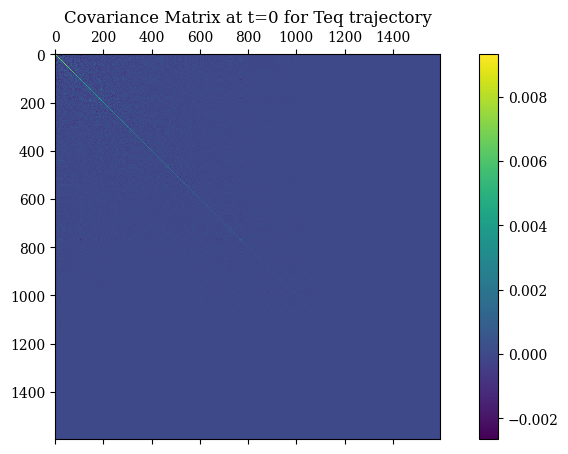

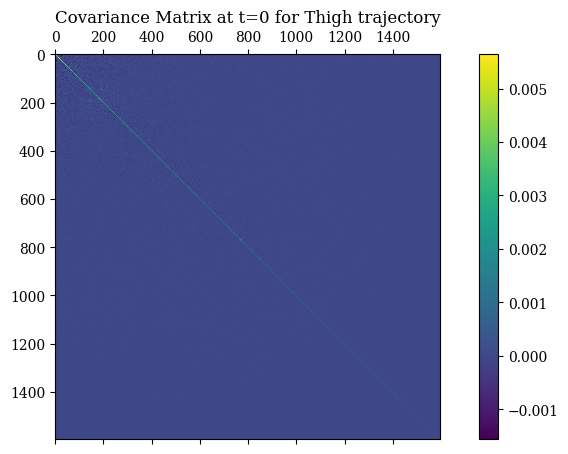

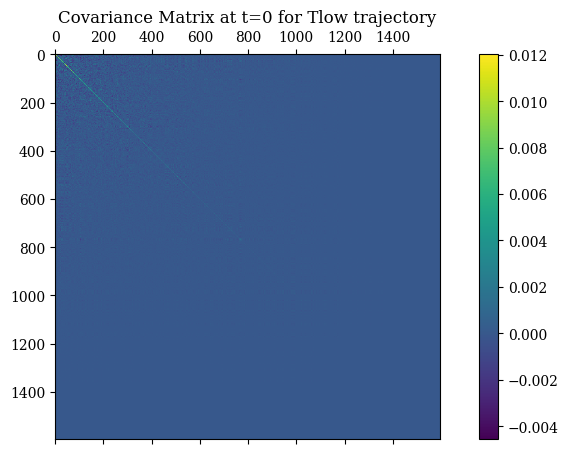

In [336]:
import matplotlib.pyplot as plt

# --- Teq ---
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.matshow(covs_Teq[0].cpu().numpy(), cmap='viridis')
fig.colorbar(im, ax=ax)
plt.title('Covariance Matrix at t=0 for Teq trajectory')
fig.savefig(f"../figures/cov_matrix_Teq_t0_{suffix}.png")
plt.show()


# --- Thigh ---
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.matshow(covs_Thigh[0].cpu().numpy(), cmap='viridis')
fig.colorbar(im, ax=ax)
plt.title('Covariance Matrix at t=0 for Thigh trajectory')
fig.savefig(f"../figures/cov_matrix_Thigh_t0_{suffix}.png")
plt.show()


# --- Tlow ---
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.matshow(covs_Tlow[0].cpu().numpy(), cmap='viridis')
fig.colorbar(im, ax=ax)
plt.title('Covariance Matrix at t=0 for Tlow trajectory')
fig.savefig(f"../figures/cov_matrix_Tlow_t0_{suffix}.png")
plt.show()


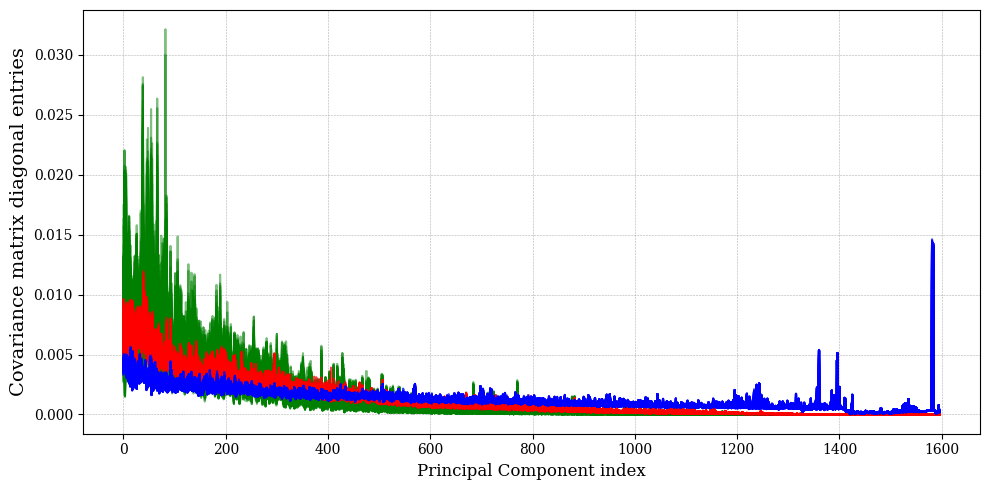

In [367]:
#plot diagonal for all covariances
ig, ax = plt.subplots(figsize=(10, 5))
ax.plot(torch.tensor([covs_Tlow[i].diag().cpu().numpy() for i in range (T)]).T , color="green", alpha = 0.5, label="$T_{\\text{low}}$")
ax.plot(torch.tensor([covs_Teq[i].diag().cpu().numpy() for i in range (T)]).T , color="red", alpha = 0.5, label="$T_{\\text{eq}}$")
ax.plot(torch.tensor([covs_Thigh[i].diag().cpu().numpy() for i in range (T)]).T , color="blue", alpha = 0.5, label="$T_{\\text{high}}$")
ax.set_xlabel("Principal Component index", fontsize=12)
ax.set_ylabel(r"Covariance matrix diagonal entries", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.4)
#ax.legend()
plt.tight_layout()
plt.savefig(f"../figures/cov_matrix_diagonal_{suffix}.png")
plt.show()